# TIF345 Advanced Simulation and Machine Learning
## Lectures 1-2: All models are wrong
### *General linear models, Bayesian regression, and Gaussian processes*
Andreas Ekström, 2025

**Watermark**

Last updated: 2025-11-02

Python implementation: CPython  
Python version       : 3.10.12  
IPython version      : 8.21.0

**Module Versions**  
`sklearn`: 1.3.0  
`scipy`: 1.11.4  
`corner`: 2.2.2  
`numpy`: 1.26.4  
`pandas`: 2.0.3  
`emcee`: 3.1.4  
`matplotlib`: 3.8.2  
`seaborn`: 0.13.2  

In [3]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode
import seaborn as sns
import random
import sklearn
sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

np.random.seed(123)

### Reality

In theory we have the luxury of contructing a reality from scratch. We have designed a simple machine that returns  work $\zeta(x)$ given effort $x$ according to

\begin{equation}
\zeta(x) = \frac{\theta_T x}{1+0.05x}.
\end{equation}

Where $\theta_T$ is a physical property of our machine that is of interest to the machine designers or anyone studying the machine itself. For small values of $x$, it basically corresponds to the machine efficiency.

In this notebook, we will set $\theta_T$ to some value of our liking, and then pretend that we do not know anything about the underlying reality of the simple machine. 

In [4]:
# Set the true physical parameter (\theta_T), and then forget about it
theta_T = 0.65 
def reality(x,theta):
    return theta*x/(1+0.05*x)

### Measuring reality

Next, we define the precision of the measurement process. For now, we will assume independently and identically distributed (i.i.d.) measurement errors $\varepsilon_i$ that all follow a normal distribution with zero mean and variance $\sigma_e^2$. In a statistical notation we write $\varepsilon_i \sim \mathcal{N}(0,\sigma_e^2)$.

In [5]:
sigma2_T = 0.1**2
print(f'sigma2_T = {sigma2_T:.4e}')
def measure(reality,x):
    noise = np.random.normal(0.0,np.sqrt(sigma2_T),len(x))
    return reality(x,theta=theta_T) + noise, noise

sigma2_T = 1.0000e-02


Once we have performed $N_d$ measurements and stored the output $y_i$ in our data$\{d_i\}_{i=1}^{N_d}$ at $\{x_i \}_{i=1}^{N_d}$ predictor points selected in the range $(x_{\rm min},x_{\rm max})$, we gather all values in the following column vectors.

Here, I choose to call everything that is data as $d_i$. Very often data is $y_i$ (or even $z_i$). Each subfield is plagued with their own jargon an notation. At times this is very confusing.

\begin{equation}
\mathbf{X} = \left[
\begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{N_d}
\end{array}
\right] ,\,\,\,\,\,\
\boldsymbol{\mathcal{D}} = \left[
\begin{array}{c}
d_1 \\
d_2 \\
\vdots \\
d_{N_d}
\end{array}
\right]
\end{equation}

In a first experiment we will perform $N_d=11$ measurements. We will come back to this cell a couple times to study the effect of havin more data. You will find that without any model discrepancy term, the inferred value for $\theta_0$ will differ significantly from the true value, even as we increase the number of measurements.

In [6]:
#measurements at n values of the control variable. Set this to ndata=11 to begin with.
Nd=10
xmin=0.01
xmax=5.0

#measure at uniform set of control/measure variables (=predictor 'X')
Xmeasure=np.arange(xmin,xmax,(xmax-xmin)/Nd)
Ydata, Yerror=measure(reality,Xmeasure)

#print the X & D if you'd like
#print(f'X = {Xmeasure}')
#print(f'D = {Ydata}')

<>:8: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\z'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/2964837696.py:8: SyntaxWarning: invalid escape sequence '\z'
  label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');


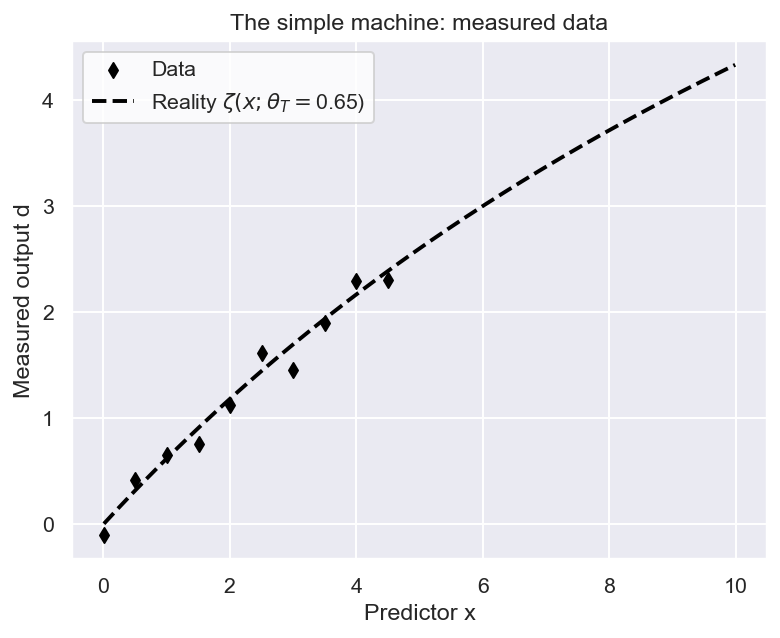

In [7]:
#Plot reality and data
#Of course, we can only 'plot reality'a theoretical exercise ;). Theory is awesome!
Xreality=np.arange(xmin,2*xmax,0.01)
zeta=reality(Xreality,theta=theta_T)

plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',marker='d',s=30);
plt.plot(Xreality,zeta,color='black',lw=2,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');

plt.xlabel(f'Predictor x');
plt.ylabel(f'Measured output d');
plt.legend(facecolor='white');
plt.title('The simple machine: measured data');
#plt.tight_layout();
#plt.savefig('./simple_machine_data.pdf')

### The model
In this example we will operate with an embarrasingly simple model to describe this spectacular data

\begin{equation}
M(\theta;x) = \theta x.
\end{equation}

In this toy example, we can imagive that we have neglected e.g. the effect of friction, which is a clear example of a model discrepancy $\delta(x)$. There can be several reasons for having model discrepancies. It might be difficult to model friction, require complex numerical operations outside our budget (timewise or moneywise), or we might be unaware that friction even exists. Still, we believe enough in our model to use it for estimating the true physical parameter $\theta_T$ inherent to the design of the machine. This example can be mapped to a situation where we are trying to extract the value of some physics parameter of more fundamental character.

Below, we will estimate $\theta_T$ using ordinary least squares (OLS) as well as the more flexible approach of Bayesian parameter estimation. You are familiar with both methods to a certain extent. 

Then we will statistically model the (unknown) model-discrepancy term using a Gaussian process (GP). A concept that you worked with during the _Learning From Data_ course. 

In the beginning, we will setup the problem such that we can evaluate most functions and posterior probability density functions (pdf:s) analytically. However, with the inclusion of more complex prior pdf:s and a GP, we will have to use Markov Chain Monte Carlo (MCMC) to draw samples from the posterior pdf for $\theta_T$. For running MCMC, we will use the Python package emcee. 

The most important lesson in this notebook, is to see, first hand, the effects of neglecting $\delta(x)$ during estimation of $\theta$. It turns out that if we neglect $\delta(x)$, then regardless of the amount of data we will never recover a realistic value or pdf for $\theta_T$, even within any reasonable uncertainty bands. This will clearly have a dramatic impact on any subsequent predictions using our model $M(\theta;x)$.

In [8]:
#define our model
def model(x,theta):
    return x*theta

#### A linear model

Our model for the simple machine is linear in $\theta$ and a trivial case of a linear model. The design matrix $\boldsymbol{\Phi}$ is given by the vector of predictors, i.e. $\boldsymbol{\Phi} =[x_0,x_1,\ldots,x_{N_d-1}]^T$.

In [9]:
#gather data vector in panda dataframe Y
pd_D = pd.DataFrame(data=Ydata,columns=['D'])

#setup the design matrix, which is trivial for our model
pd_Phi = pd.DataFrame(data=Xmeasure**1, columns=['X'])

Np = len(pd_Phi.to_numpy()[0])

#print the dataframes if you'd like
#print(pd_D)
#print(pd_Phi)

## Ordinary Least Squares (OLS)

To find the value for the physical parameter that makes the model fit best to data, we can setup a least-squares objective function

\begin{equation}
\chi^2(\boldsymbol{\theta}) = (\boldsymbol \Phi \boldsymbol\theta -\boldsymbol{\mathcal{D}})^T(\boldsymbol \Phi \boldsymbol\theta -\boldsymbol{\mathcal{D}}),
\end{equation}
and then minimize with respect to $\theta$. That is, we try to find
\begin{equation}
\hat{\boldsymbol \theta} = {\rm argmin} \chi^2(\boldsymbol \theta).
\end{equation}

The is equivalent to finding the ordinary least squares estimator $\hat{\boldsymbol \theta}$ for the physical parameter, and is given by
$\hat{\boldsymbol \theta} = (\boldsymbol \Phi^{T} \boldsymbol \Phi)^{-1}\boldsymbol  \Phi^T \boldsymbol{\mathcal{D}}$.

>## <font color='red'>Exercise: </font> 
Derive the normal equations.

We can use the regression residuals $\hat{\boldsymbol \varepsilon} =  \hat{\boldsymbol{\mathcal{D}}}- \boldsymbol{\mathcal{D}}$, where $\hat{\boldsymbol{\mathcal{D}}}$ is the data prediction based on the OLS estimate, to estimate the  variance in our sample
\begin{equation}
s^2 = \frac{\hat{\boldsymbol \varepsilon}^T\hat{\boldsymbol \varepsilon}}{N_d-N_p},
\end{equation}
where $N_p$ denotes the number of parameters in the model, i.e. $p=1$. If our model is identical to the the underlying process from where we draw the data, then in the limit of $N_d \rightarrow \infty$, our estimator $s^2\rightarrow \sigma^2_e$. This is sometimes called the mean squared error.

In [10]:
#ols estimator for physical parameter theta
Phi = pd_Phi.to_numpy()
D   = pd_D.to_numpy()

ols_cov   = np.linalg.inv(np.matmul(Phi.T,Phi))
ols_xTd   = np.matmul(Phi.T,D)
ols_theta = np.matmul(ols_cov,ols_xTd)

hatD   = model(Xmeasure,ols_theta)
hatEps = (hatD - D.T)
ols_s2 = (np.dot(hatEps,hatEps.T)/(Nd-Np))

print(f'Ndata = {Nd}')
print(f'OLS theta \t{ols_theta[0][0]:<30.6f}')
print(f'theta_true \t{theta_T:<30.6f}\n')
print(f'OLS s2 \t\t{ols_s2[0][0]:<30.6f}')
print(f'sigma2_true \t{sigma2_T:<30.6f}\n')

Ndata = 10
OLS theta 	0.544206                      
theta_true 	0.650000                      

OLS s2 		0.019788                      
sigma2_true 	0.010000                      



>## <font color='red'>Exercise: </font>
What happens when you (decrease) increase the number of data points? Try using ($N_d=3$) $N_d=200$ instead? Will you ever find $\hat{\boldsymbol \theta} = \boldsymbol \theta_T$ under the present circumbstances? If not, why?!

### Confidence interval
With OLS we do not obtain a probability density function
(pdf) for $\theta$.  We only get a point estimate, i.e. a single
value. To partly remedy this it is possible to define an interval estimate, a so-called
confidence interval $I_{\alpha}$ for $\hat{\theta}$ with upper ($U$)
and lower ($L$) limits according to

\begin{equation}
  I_{\alpha}(\theta) = [L,U]: p(L(F) \leq \theta \leq U(F) | F\sim\theta) = 1-\alpha,
\end{equation}

where $\alpha\in[0,1]$. This basically states that if we sample future
data $F$, governed by the parameter $\theta$, there is a
$1-\alpha$ probability that the interval $[L(F),U(F)]$ contains
$\theta$. Strictly speaking, this only applies if the regression model
is identical to the real process that generates the data. 

In the next lecture we will use a Bayesian strategy to derive the
expressions for $I_{\alpha}(\theta)$. For now we simply state the 
formula for extracting the CI's for the parameters in a OLS analysis of a GLM with
an unknown normal i.i.d. error term $\mathcal{N}(0,\sigma_e^2 \mathbf{1})$

\begin{equation}
  \hat{\theta} \pm  t_{N_d-N_p}(1-\alpha/2) \cdot \sqrt{s^2*(\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}}
\end{equation}

where $t_{N_d-N_p}(q)$ is the inverse of the cumulative distribution
function (CDF) for the Student's t-distribution. $\sqrt{s^2*(\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}}$ is the sample variance of $\hat{\theta}$

In scipy you can compute the inverse of the CDF using the **ppf** function. For the t-distribution you should call: 

> t.ppf(1 - alpha / 2, df = N_d-N_p)

In [11]:
# CI
CI_alpha = 0.1
t_nu = t.ppf(1 - CI_alpha / 2, df = len(D)-1)
ols_var_theta = ols_s2*ols_cov
CI_low = ols_theta - np.sqrt(ols_var_theta)*t_nu
CI_high = ols_theta + np.sqrt(ols_var_theta)*t_nu
print(f'We obtain the following {100*(1-CI_alpha):<5.1f}% confidence interval from the OLS analysis:')
print(f'[{CI_low[0][0]:<6.3f},{CI_high[0][0]:6.3f}]')

We obtain the following 90.0 % confidence interval from the OLS analysis:
[0.514 , 0.575]


In [12]:
# Extend the range such that we also make some predictions with our model
Xpredict   = np.arange(0,2*xmax,0.05)
pd_Phi_new = pd.DataFrame(data=Xpredict, columns=['X'])
Phi_new    = pd_Phi_new.to_numpy();

Xnew = np.array([6.0])

### The prediction interval

Similar to a CI, we can compute the prediction interval (PI). In the next lecture we will use a Bayesian strategy to derive the expressions for the PI.

<>:15: SyntaxWarning: invalid escape sequence '\z'
<>:18: SyntaxWarning: invalid escape sequence '\^'
<>:15: SyntaxWarning: invalid escape sequence '\z'
<>:18: SyntaxWarning: invalid escape sequence '\^'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/2830899522.py:15: SyntaxWarning: invalid escape sequence '\z'
  label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/2830899522.py:18: SyntaxWarning: invalid escape sequence '\^'
  label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}');


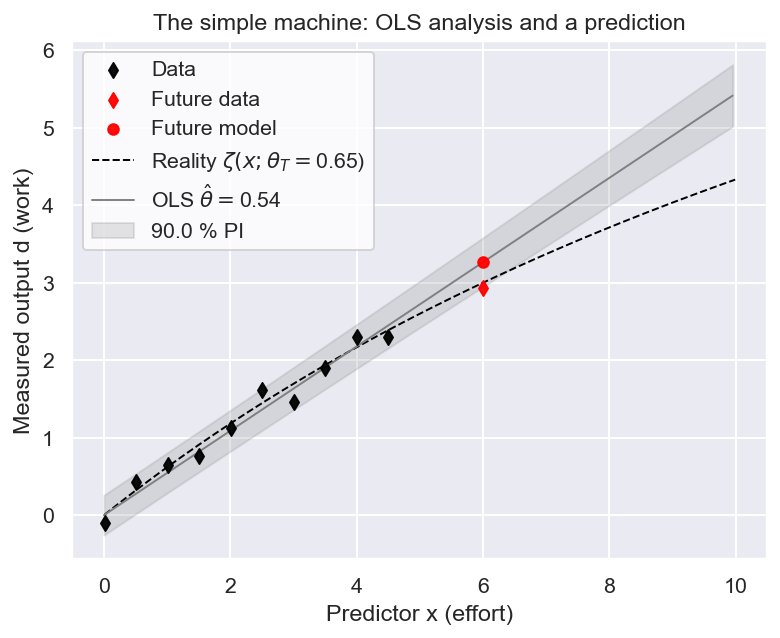

In [13]:
#Plot reality, data, and the prediction from the OLS-fitted model
ols_prediction = model(Xpredict,theta = ols_theta)
model_new = model(Xnew,theta = ols_theta)
reality_new = measure(reality,Xnew)[0]
# prediction interval
ols_var_y_PI = np.diag(ols_s2*(np.eye(len(Phi_new)) + np.matmul(np.matmul(Phi_new,ols_cov),Phi_new.T)))
# prediction interval
ols_PI_prediction_L = model(Xpredict,theta = ols_theta) - np.sqrt(ols_var_y_PI)*t_nu
ols_PI_prediction_U = model(Xpredict,theta = ols_theta) + np.sqrt(ols_var_y_PI)*t_nu
plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
plt.scatter(Xnew,reality_new,color='red',zorder=40, alpha=0.95,s=30,marker="d",label='Future data')
plt.scatter(Xnew,model_new,color='red',zorder=40, alpha=0.95,s=30,marker="o",label='Future model')
        
plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
ols='OLS'
plt.plot(Xpredict, ols_prediction.T, color='gray',linewidth=1,
         label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}');
plt.fill_between(Xpredict,ols_PI_prediction_L[0].T,ols_PI_prediction_U[0].T,alpha=0.2,color='gray',
                 label=f'{100*(1-CI_alpha):<5.1f}% PI');

plt.xlabel(f'Predictor x (effort)');
plt.ylabel(f'Measured output d (work)');
plt.legend(facecolor='white');
plt.title('The simple machine: OLS analysis and a prediction');
#plt.tight_layout();
#plt.savefig('./simple_machine_data_ols_predict.pdf')

>## <font color='red'>Exercise: </font>
The code snippet below will 'measure' a _linear_ system and extract the OLS estimator for the slope. That is, we have a model that reflects reality exactly and there is no need for a model discrepancy term. This is a textbook example, and we can make sure that the model is _not wrong_. This is on purpose and enables us to study the CI in an ideal setting. In each experiment $N_d$ data points are taken. The _same_ experiment is then repeated thousands of times. In each experiment, the CI is extracted, and we check if the true parameter value lies inside the CI. 

90-percent CI: overlap with true theta value in 87 -percent of the experiments


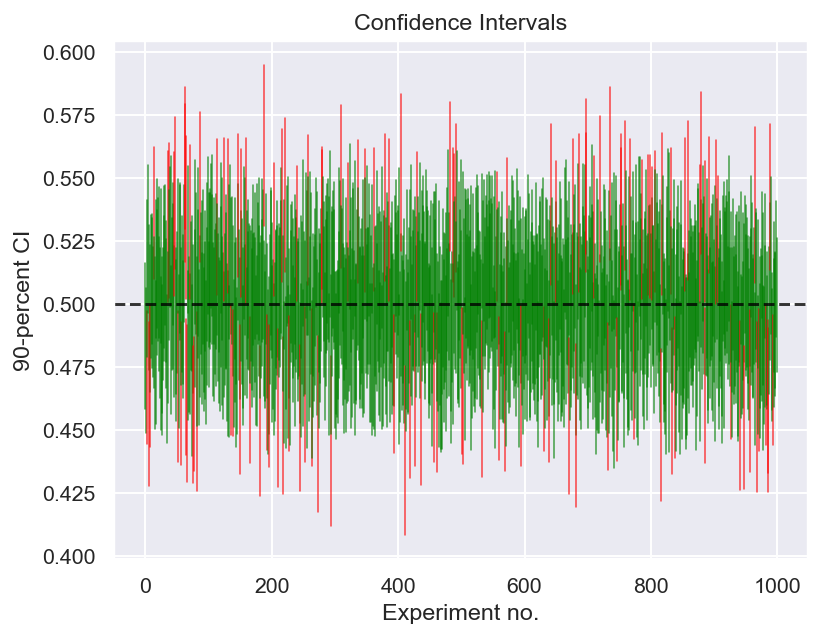

In [14]:
# interlude: simulate confidence intervals
true_parameter_value = 0.5
def measure_linear_process(x):
    sigma_e = 0.1
    return x*true_parameter_value + np.random.normal(0,sigma_e,len(x))

this_CI_alpha = 0.1
#this simple function will return (1-alpha)*100% CI (confidence interval)
#for the slope parameter in the linear model above
def ols(x,d):
    ols_cov   = 1/np.sum(x**2)
    ols_xTd   = np.sum(x*d)
    ols_theta = ols_cov*ols_xTd
    s2 = np.sum((ols_theta*x-d)**2)/(len(d)-1)
    ols_var_theta = s2*ols_cov
    # CI
    CI_low = ols_theta - np.sqrt(ols_var_theta)*t.ppf(q = 1 - this_CI_alpha / 2, df = len(d)-1)
    CI_high = ols_theta + np.sqrt(ols_var_theta)*t.ppf(q = 1 - this_CI_alpha / 2, df = len(d)-1)

    return [CI_low, CI_high]

#The calculation of the CI in the ols function above might 
#seem a bit obscure unless you remember the specifics about 
#confidence intervals from your statistics course

#The code below repeats the experiment 2000 times
repeat_experiment = 1000

#and in each experiment the measure_linear_process is evaluated for
#100 different (constant) values of the control variable 'x'
measurements_per_experiment = 100

#the constant 'x' values
xvals = np.sort(np.random.uniform(0,1,measurements_per_experiment))
ols_in_interval = 0
CIs = []
for nexp in np.arange(0,repeat_experiment):
    # get the new data. There's a normally distributed random number in there
    data = measure_linear_process(xvals)
    # extract CI's
    CI = ols(xvals,data)
    # check if the CI overlaps with the true (but unknown) parameter value
    if CI[1] >= true_parameter_value and CI[0] <= true_parameter_value:
        # if so, count +1
        ols_in_interval += 1
        CIs.append([CI,'green'])
    else:
        CIs.append([CI,'red'])        
        
# in how many of the repeated experiments did 
# the CI overlap with the true parameter value?
#
# the infinte limit of experiments we should find hits = (1-alpha)*100
#
# This is the meaning of a confindence interval. Nothing else.
hits = 100*ols_in_interval/repeat_experiment
print(f'{(1-this_CI_alpha)*100:2.0f}-percent CI: overlap with true theta value in {hits:<3.0f}-percent of the experiments')

for idx, CI in enumerate(CIs):
    plt.plot([idx,idx],[CI[0][0],CI[0][1]], color=CI[1],linewidth=0.8,alpha=0.7);
    
plt.axhline(true_parameter_value ,color='black',linestyle='--',alpha=0.8);
plt.title('Confidence Intervals');
plt.xlabel('Experiment no.');
plt.ylabel(f'{(1-this_CI_alpha)*100:2.0f}-percent CI');

# Bayesian parameter estimation

As you known from previous courses, e.g. TIF285 _Learning from data_, we can use Bayes' theorem to compute the posterior probability for some model $M$ given data $D$

\begin{equation}
p(M|\boldsymbol{\mathcal{D}}) = \frac{p(\boldsymbol{\mathcal{D}}|M)p(M)}{p(\boldsymbol{\mathcal{D}})}.
\end{equation}

We refer to $p(\boldsymbol{\mathcal{D}}|M)$ and $p(M)$ as the prior and the likelihood, respectively. The denominator $p(\boldsymbol{\mathcal{D}})$ is called the marginal likelihood. 

We can use our model to link predictors $\mathbf{X}$, via the design matrix $\boldsymbol \Phi$, to data $\boldsymbol{\mathcal{D}}$ according to

\begin{equation}
\boldsymbol{\mathcal{D}} = \boldsymbol \Phi \boldsymbol \theta + \boldsymbol \varepsilon.
\end{equation}

We will assume i.i.d. data errors $\boldsymbol{\varepsilon}=\{\varepsilon_i\}_{i=1}^{N_d}$ such that the error for each datum is normally distributed with the same variance, i.e. $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$. 

We can use Bayes' theorem to express

\begin{equation}
p(\boldsymbol \theta,\sigma^2 | \boldsymbol{\mathcal{D}}) = \frac{p(\boldsymbol{\mathcal{D}}|\boldsymbol \theta,\sigma^2)p(\boldsymbol \theta,\sigma^2)}{p(\boldsymbol{\mathcal{D}})}.
\end{equation}

### The Likelihood

If we assume a finite variance $\sigma^2$, the principle of maximum entropy dicates the least informative constraint for the probability of the data conditioned on the parameters, i.e. the likelihood, is given by a normal distribution. In our case we have i.i.d. errors parametrized by a common variance $\sigma^2$

\begin{equation}
p(\boldsymbol{\mathcal{D}}|\boldsymbol \theta,\sigma^2) = \mathcal{N}(\boldsymbol{\mathcal{D}} | \boldsymbol{\Phi}\boldsymbol \theta,\sigma^2\mathbf{1}) = \left(\frac{1}{2\pi\sigma^2}\right)^{n/2} {\rm exp}\left\{ -\frac{1}{2}\frac{(\boldsymbol{\mathcal{D}} - \boldsymbol{\Phi}\boldsymbol\theta)^T(\boldsymbol{\mathcal{D}} - \boldsymbol{\Phi}\boldsymbol\theta)}{\sigma^2} \right\}.
\end{equation}

The evidence, or marginal likelihood, is defined as

\begin{equation}
p(\boldsymbol{\mathcal{D}}) = \int p(\boldsymbol{\mathcal{D}}|\boldsymbol\theta,\sigma^2)p(\boldsymbol\theta,\sigma^2) \, d\boldsymbol\theta d\sigma^2.
\end{equation}

We must also define a prior $p(\boldsymbol\theta,\sigma^2)$ to reflect our *prior knowledge* about $\boldsymbol \theta$ and $\sigma^2$ before looking at the data $\boldsymbol{\mathcal{D}}$. 

## Conjugate priors

In this lecture we will begin by exploring so-called conjugate priors. A prior is conjugate to the likelihood if the posterior and the prior belong to the same family of probability distributions; e.g. normal, poisson, exponential, gamma, etc. The  advantage of using conjugate priors is that we can obtain a closed form expression for the posterior pdf. 

Later on, we will see several examples where we have to resort to numerical evaluation of the posterior using Markov Chain Monte Carlo evaluation. 

### The Normal-Inverse-Gamma (NIG) prior

A NIG prior is conjugate to a likelihood with unknown $\boldsymbol \theta$ and $\sigma^2$, and is defined as

\begin{equation}
p(\boldsymbol\theta,\sigma^2) = p(\boldsymbol\theta|\sigma^2)p(\sigma^2) = \mathcal{N}(\boldsymbol \theta| \mathbf{\mu}_0,\sigma^2 \boldsymbol \Sigma_0)\cdot\mathcal{IG}(\sigma^2|\alpha_0,\beta_0) \equiv \mathcal{NIG}(\boldsymbol \theta, \sigma^2 |\boldsymbol \mu_0,\boldsymbol \Sigma_0,\alpha_0,\beta_0).
\end{equation}

It consists of the product of a normal and an inverse-gamma distribution. The $\mathcal{NIG}(\boldsymbol \theta, \sigma^2 |\mu_0,\Sigma_0,\alpha_0,\beta_0)$ is a joint pdf for (vector) $\boldsymbol \theta$ and (scalar) $\sigma^2$. The generalization to a fully multivariate version for the inverse-gamma pdf, i.e. a distribution that includes covariance matrices, is an inverse-Wishart pdf.

We note that the parameter prior is defined by the prior mean $\mu_0$ and prior covariance $\Sigma_0$. The prior for the variance $\sigma^2$ is parametrized by $\alpha_0,\beta_0$, and such parameters are called hyperparameters, and a prior for a hyperparameter is called a hyperprior. Cleary, we have several hyperparameters, and we will assign definite values to these, or equivalently a hyperprior in the form of a delta function. Note that the inverse-gamma pdf is only defined for $\alpha_0,\beta_0 >0$.

You can use the provided notebook **Some_stats_distributions** to play around with the probability distributions we will encounter in this lecture.

### The resulting posterior

Combining the conjugate NIG prior for $\boldsymbol{\theta}$ and $\sigma^2$ with the normal likelihood above yields a closed- form expression for the posterior pdf. It is of course a NIG pdf given by
\begin{align}
  \begin{split}
  p(\boldsymbol{\boldsymbol{\theta}},\sigma^2|\boldsymbol{\mathcal{D}}){}& = \mathcal{NIG}(\boldsymbol{\boldsymbol{\theta}},\sigma^2|\tilde{\boldsymbol{\mu}},\tilde{\boldsymbol{\Sigma}},\tilde{\alpha},\tilde{\beta}),\,\, {\rm with}\\
  {}& \tilde{\boldsymbol{\mu}} = \tilde{\boldsymbol \Sigma}(\boldsymbol \Sigma_0^{-1}\boldsymbol \mu_0 + \boldsymbol \Phi^T\boldsymbol{\mathcal{D}}) \\
  {}& \tilde{\boldsymbol{\Sigma}} = (\boldsymbol \Sigma_0^{-1} + \boldsymbol \Phi^T\boldsymbol \Phi )^{-1}\\
  {}& \tilde{\alpha} = \alpha_0 + N_d/2 \\
  {}& \tilde{\beta} = \beta_0 + \frac{1}{2}\left(\boldsymbol \mu_0^{T} \boldsymbol \Sigma_0^{-1}\boldsymbol \mu + \boldsymbol{\mathcal{D}}^T \boldsymbol{\mathcal{D}} -\tilde{\boldsymbol \mu}^T \tilde{\boldsymbol \Sigma}^{-1} \tilde{\boldsymbol \mu}\right) \\
  \end{split}
\end{align}

#### Define some functions for the normal, t, gamma, and inverse-gamma  distribution

In [15]:
def normal_distribution(mu,sigma2):
    return norm(loc=mu,scale=np.sqrt(sigma2)), [mu,sigma2]

def ig_distribution(alpha,beta):
    return invgamma(a=alpha,scale=beta), [alpha,beta]

def t_distribution(nu,mu,sigma_hat2):
    return t(df=nu,loc=mu,scale=np.sqrt(sigma_hat2)), [nu,mu,sigma_hat2]

def g_distribution(alpha,beta):
    return gamma(a=alpha,scale=beta), [alpha,beta]

def nig(th,s2,mu0,Sigma0,alpha,beta):

    if alpha<=0:
        print('error alpha<=0')
        return 0
    if beta<=0:
        print('error beta<=0')
        return 0
    
    NIG = norm.pdf(th,loc=mu0,scale=np.sqrt(s2)*np.sqrt(Sigma0))*invgamma.pdf(s2,a=alpha,scale=beta) 

    return NIG
    
# helper function to convert the IG mean,mode to alpha,beta
def mean_mode_2_IG_alpha_beta(mean,mode):
    alpha = (mode + mean)/(mean-mode)
    beta = (2 * mode * mean)/(mean-mode)
    return alpha, beta

# helper function to convert the G mean,variance to alpha,beta
def mean_variance_2_G_alpha_beta(mean,variance):
    alpha = mean**2/variance
    beta = variance/mean
    return alpha, beta

### One can show that marginal distributions are given by
$$
\begin{align}
  \begin{split}
    p(\boldsymbol{\theta}|\boldsymbol{\mathcal{D}}) {}& =\int \mathcal{NIG}(\boldsymbol{\theta},\sigma^2|\tilde{\boldsymbol{\mu}},\tilde{\boldsymbol{\Sigma}},\tilde{\alpha},\tilde{\beta})\,d\sigma^2 = \mathcal{T}_{2\tilde{\alpha}}(\boldsymbol{\theta}|\tilde{\boldsymbol{\mu}},(\tilde{\beta}/\tilde{\alpha})\tilde{\boldsymbol{\Sigma}})\\
    p(\sigma^2|\boldsymbol{\mathcal{D}}) {}& = \int \mathcal{NIG}(\boldsymbol{\theta},\sigma^2|\tilde{\boldsymbol{\mu}},\tilde{\boldsymbol{\Sigma}},\tilde{\alpha},\tilde{\beta})\,d\boldsymbol{\theta} = \mathcal{IG}(\sigma^2|\tilde{\alpha},\tilde{\beta}).
  \end{split}
\end{align}
$$
You will demonstrate this in Lab 1

### An improper prior: connecting with the OLS result

In the limit of extremely vague prior information, we can set $\boldsymbol \mu_0 = 0$ and $\boldsymbol \Sigma_0 \rightarrow \infty$. This is in accordance with not having any preferred value for the model parameter(s) before looking at the data. Moreover, if we also assume $\alpha = -N_p/2$ and $\beta \rightarrow 0$, then the NIG prior approaches $p(\boldsymbol \theta,\sigma^2) \propto \sigma^{-2}$. This is often referred to as an uninformative NIG prior. 

With this setting we recover the OLS results above. This partly motivates why we call it an uninformative prior.  This is connected with the so-called Jeffreys prior and the attempt towards minimizing prior influence. Clearly, there is no point in being bayesian if you do your best to avoid the prior. Also, we always have a prior!

In [16]:
#computes the posterior NIG parameters from data
def posterior_nig_prior(D_, Phi_, mu0, Sigma0, a0, b0, uninformative = False):
    # data matrix
    D = D_['D'].to_numpy()
    Nd = len(D)
    # design matrix
    Phi = Phi_.to_numpy()
    Np = len(Phi[0])
    
    Sigma0_inv = np.linalg.inv(Sigma0)
    
    #option B: uninformative improper prior
    if uninformative is True:
        mu0 = np.ones(Np)*0
        Sigma0_inv = np.diag(np.square(np.ones(Np)*0.0))
        a0 = -Np/2
        b0 = 0
    
    #posterior
    Sigma_inv = Sigma0_inv + np.matmul(Phi.T,Phi)
    Sigma = np.linalg.inv(Sigma_inv)
    mu = np.matmul(Sigma,np.matmul(Sigma0_inv,mu0) + np.matmul(Phi.T,D))
    
    a = a0 + Nd/2
    
    mSm = np.matmul(np.matmul(mu0.T,Sigma0_inv),mu0)
    DtD = np.matmul(D.T,D)
    pSp = np.matmul(np.matmul(mu.T,Sigma_inv),mu)
    b = b0 + 0.5*(mSm + DtD - pSp)
    
    #posterior (tilde) parameters
    return mu, Sigma, a, b

In [17]:
# plot 2d (theta,sigma2) NIG pdf 
def nig_plot(mu,sigma,alpha,beta, plot_pars = []):
    print(f'NIG parameters:\n (mu0,Sigma0,a0,b0) = {mu,sigma,alpha,beta}');
    if len(sigma) > 1:
        print(f'this routine cannot plot beyond 1d theta')
    lamb = sigma[0][0]
    projected_mode_X  = mu
    projected_sigma_X = np.sqrt(lamb*beta/(alpha-1))
    projected_mode_s2 = beta/(alpha+1.5)
    print(f'projected_mode_X  = {projected_mode_X}');
    print(f'projected_sigma_X = {projected_sigma_X}');
    print(f'projected_mode_s2 = {projected_mode_s2}');

    # Ensure mu0 and Sigma0 are scalars if they are arrays
    mu_scalar = mu.item() if np.ndim(mu) > 0 else mu
    sigma_scalar = sigma.item() if np.ndim(sigma) > 0 else sigma

    ngrd   = 100
    if not plot_pars:
        th_min = projected_mode_X - 6*projected_sigma_X
        th_max = projected_mode_X + 6*projected_sigma_X
        s2_min = 0.5*projected_mode_s2
        s2_max = 2*projected_mode_s2
        print(f'plot_pars = [{th_min[0]},{th_max[0]},{s2_min},{s2_max}]');
    else:
        th_min = plot_pars[0]
        th_max = plot_pars[1]
        s2_min = plot_pars[2]
        s2_max = plot_pars[3]
    
    if s2_min <= 0:
        s2_min = 1e-6

    th = np.linspace(th_min,th_max,ngrd)
    s2 = np.linspace(s2_min,s2_max,ngrd)
    th_grid,s2_grid = np.meshgrid(th,s2)

    nig_pdf = np.zeros((ngrd,ngrd))

    for th_idx, th_val in enumerate(th):
        for s2_idx, s2_val in enumerate(s2):
            nig_pdf[s2_idx][th_idx] = nig(th_val,s2_val,mu_scalar,sigma_scalar,alpha,beta)
    
    fig1 = plt.figure(figsize=(5,5))
    contours = plt.contour(th_grid, s2_grid, nig_pdf, 5, colors='black')
    plt.imshow(nig_pdf, extent=[th_min,th_max,s2_min,s2_max], origin='lower',cmap='afmhot', alpha=0.9, aspect='auto');
    #plt.colorbar();
    plt.title(r'$\mathcal{NIG}(\mu=%.2f,\Sigma=%.2f,\alpha=%.2f,\beta=%.2f)$'%(mu_scalar,sigma_scalar,alpha,beta))
    plt.xlabel(r'$\theta$');
    plt.ylabel(r'$\sigma^2$');
    #plt.tight_layout();
    #plt.savefig('./NIG_informative_posterior.pdf');
    
    return fig1

#alpha_test = 1
#beta_test  = 1
#mu_test    = 0
#sigma_test = 1
#nig_plot(mu_test,sigma_test,alpha_test,beta_test,plot_pars = [100,-2,+2,0,1.5]);

In [18]:
# Using a NIG prior yields a NIG posterior
IG_mean = 0.05**2
IG_mode = 0.049**2
a0, b0  = mean_mode_2_IG_alpha_beta(IG_mean,IG_mode)

#a0 = 1.01
#b0 = 1.0

#option A: informative prior. Here you can define your prior according to your prior information/beliefs
mu0 = np.ones(Np)*1.0
lamb=2000.0
Sigma0 = np.diag(np.square(np.ones(Np)))*lamb

print(f'a0 = {a0}');
print(f'b0 = {b0}');
print(f'Sigma0 = {Sigma0}');
print(f'mu0 = {mu0}');

# option B: override everything above and use an uninformative ~1/sigma^2 prior
# correponding to an improper infinite ~uniform prior in theta and log(sigma2)
# this will make the Bayesian approach return the OLS results...
uninformative = False

a0 = 49.50505050505045
b0 = 0.12126262626262616
Sigma0 = [[2000.]]
mu0 = [1.]


NIG parameters:
 (mu0,Sigma0,a0,b0) = (array([1.]), array([[2000.]]), 49.50505050505045, 0.12126262626262616)
projected_mode_X  = [1.]
projected_sigma_X = 2.2360679774997902
projected_mode_s2 = 0.0023774631151599174


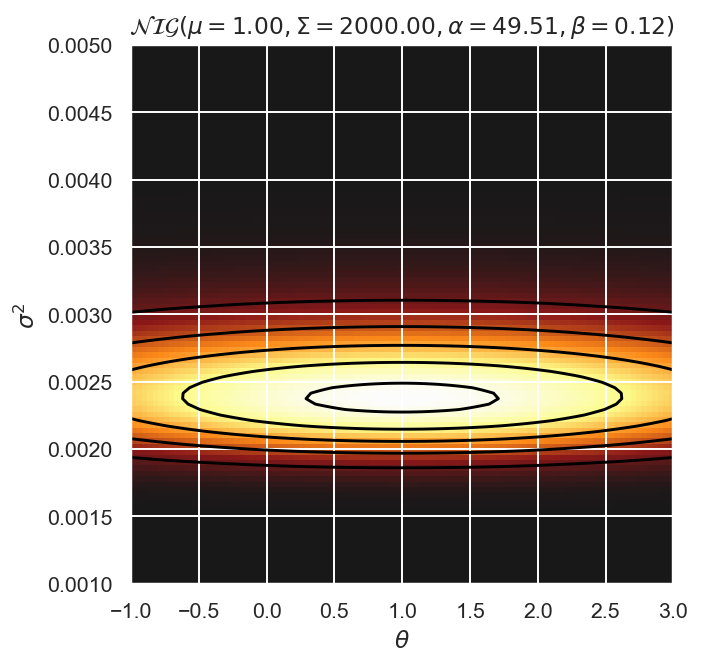

In [19]:
if not uninformative:
    nig_plot(mu0,Sigma0,a0,b0,plot_pars = [-1,3,0.001,0.005]);

 - Posterior - 
mu 	[0.54420935]
Sigma 	[[0.01400249]]
alpha 	54.50505050505045
beta 	0.21036000063118251
s2 estimator:0.003859458869993901
 - Marginal sigma^2 Posterior: IG-distribution - 
mode 	0.0037899253980868226
mean 	0.003931591478664733
var 	2.943985655936527e-07
std 	0.0005425850768254253
 - Marginal theta Posterior: T-distribution - 
mean 	[[0.54420935]]
var 	[[5.50520585e-05]]
std 	[[0.00741971]]
s2 	0.003859458869993901
theta: 90.00 BCI interval (array([[0.53201385]]), array([[0.55640485]]))

Above we obtained the following 90.0 % confidence interval from the OLS analysis:
[0.513693 , 0.574720]

OLS th 	0.544206                      
OLS s2 	0.019788                      

theta_true 	0.650000                      
sigma2_true 	0.010000                      
NIG parameters:
 (mu0,Sigma0,a0,b0) = (array([0.54420935]), array([[0.01400249]]), 54.50505050505045, 0.21036000063118251)
projected_mode_X  = [0.54420935]
projected_sigma_X = 0.007419707440149915
projected_mode_s2 = 0.

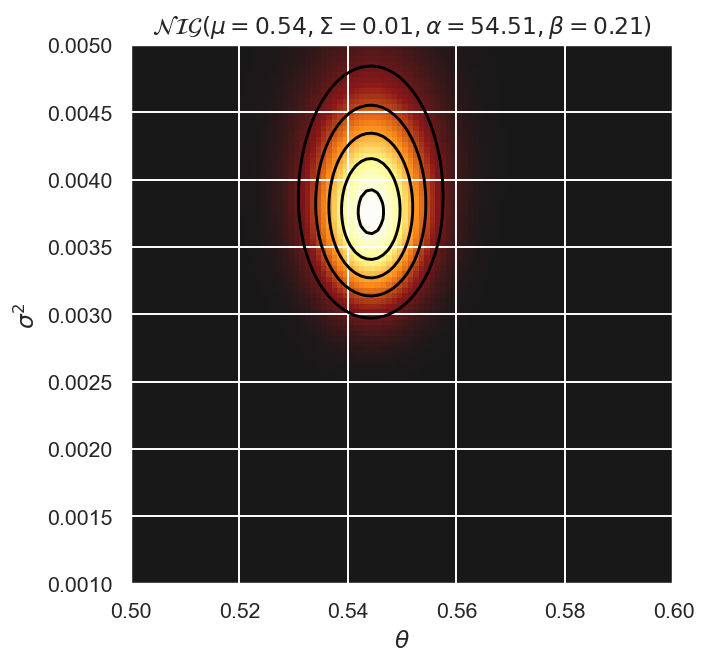

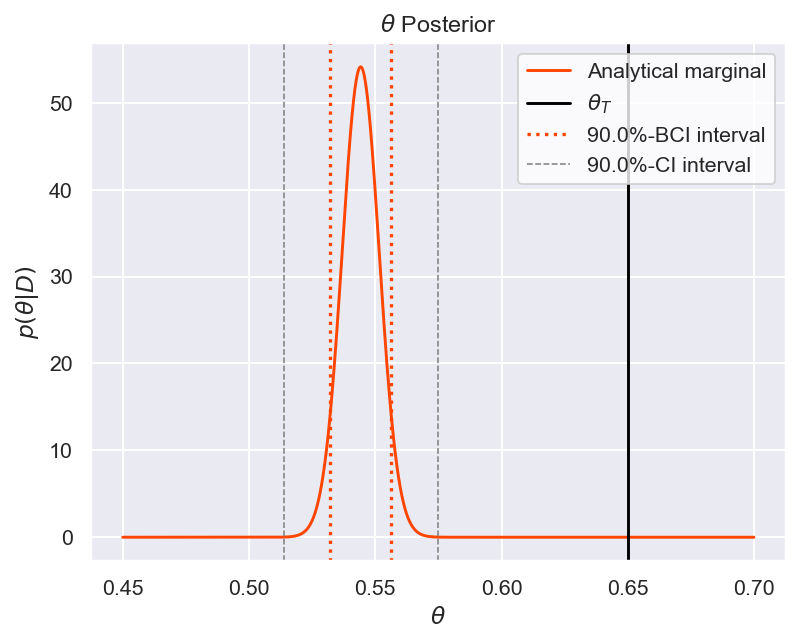

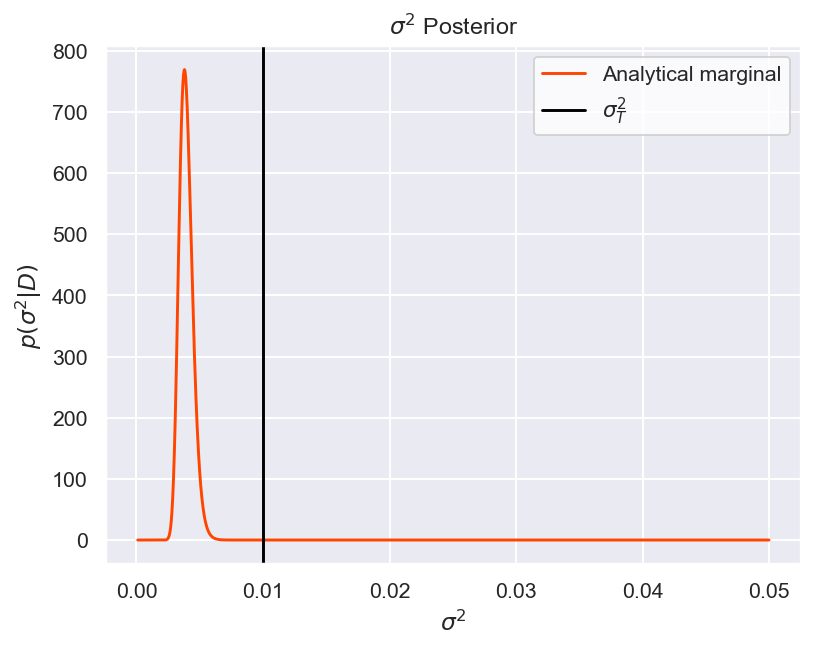

In [20]:
mu, Sigma, alpha, beta = posterior_nig_prior(pd_D,pd_Phi, mu0, Sigma0, a0, b0, uninformative)

df = 2*alpha

print(f' - Posterior - ')
print(f'mu \t{mu}')
print(f'Sigma \t{Sigma}')
print(f'alpha \t{alpha}')
print(f'beta \t{beta}')

marginal_sigma2, _ = ig_distribution(alpha,beta)
sigma2_mode = beta/(alpha+1)
print(f's2 estimator:{beta/alpha}')

print(f' - Marginal sigma^2 Posterior: IG-distribution - ')

print(f'mode \t{sigma2_mode}')
print(f'mean \t{marginal_sigma2.mean()}')
print(f'var \t{marginal_sigma2.var()}')
print(f'std \t{marginal_sigma2.std()}')

marginal_theta, _ = t_distribution(df, mu, Sigma*(beta/alpha))
print(f' - Marginal theta Posterior: T-distribution - ')
print(f'mean \t{marginal_theta.mean()}')
print(f'var \t{marginal_theta.var()}')
print(f'std \t{marginal_theta.std()}')
print(f's2 \t{beta/alpha}')

#extract bayesian credible interval
bci = 0.90

theta_bci_interval = marginal_theta.interval(confidence=bci)

print(f'theta: {100*bci:.2f} BCI interval {theta_bci_interval}')

print();
print(f'Above we obtained the following {100*(1-CI_alpha):<5.1f}% confidence interval from the OLS analysis:')
print(f'[{CI_low[0][0]:<9.6f},{CI_high[0][0]:9.6f}]')

print()
print(f'OLS th \t{ols_theta[0][0]:<30.6f}')
print(f'OLS s2 \t{ols_s2[0][0]:<30.6f}')
print()
print(f'theta_true \t{theta_T:<30.6f}')
print(f'sigma2_true \t{sigma2_T:<30.6f}')


if uninformative:
    nig_plot(mu,Sigma,alpha,beta,plot_pars = [0.50,0.70,0.0015,0.01]);
else:
    nig_plot(mu,Sigma,alpha,beta,plot_pars = [0.5,0.6,0.001,0.005]);
    
fig2 = plt.figure();
theta_plot_vals=np.arange(0.45,0.70,0.0001)
plt.xlabel(f'$\\theta$')
plt.ylabel(f'$p(\\theta|D)$');
plt.plot(theta_plot_vals,marginal_theta.pdf(theta_plot_vals)[0],color="orangered",label='Analytical marginal');
plt.axvline(theta_T,color='black',linestyle='-',linewidth=1.5,label=f'$\\theta_T$');
plt.axvline(theta_bci_interval[0],color='orangered',linestyle=':',linewidth=1.7,label=f'{bci*100}%-BCI interval');
plt.axvline(theta_bci_interval[1],color='orangered',linestyle=':',linewidth=1.7)
plt.axvline(CI_low[0][0],color='gray',linestyle='--',linewidth=0.8,label=f'{bci*100}%-CI interval');
plt.axvline(CI_high,color='gray',linestyle='--',linewidth=0.8)

plt.title(f'$\\theta$ Posterior');
plt.legend(facecolor='white');
#plt.savefig('./theta_marginal.pdf')

fig3 = plt.figure();
if uninformative:
    sigma2_plot_vals=np.arange(0.0001,0.04,0.00001)
else:
    sigma2_plot_vals=np.arange(0.0001,0.05,0.00001)

plt.xlabel(f'$\\sigma^2$')
plt.ylabel(f'$p(\\sigma^2|D)$');
plt.plot(sigma2_plot_vals,marginal_sigma2.pdf(sigma2_plot_vals),color="orangered",label='Analytical marginal');
plt.axvline(sigma2_T,color='black',linestyle='-',linewidth=1.5,label=f'$\\sigma^2_T$');
plt.title(f'$\\sigma^2$ Posterior');
plt.legend(facecolor='white');

>## <font color='red'>Exercise: </font> 
Use the notebook and try out a few different scenarios: e.g. a strong prior where you for some reason firmly believe that $\theta$ should be located a larger positive values. Try the same with just 10 data points (default) and then see what happens as you measure plenty of data (e.g. Nd=200).

Plot the resulting model prediction using the posterior $\theta$ mode and compare with the full OLS prediction from above

<>:3: SyntaxWarning: invalid escape sequence '\z'
<>:6: SyntaxWarning: invalid escape sequence '\^'
<>:3: SyntaxWarning: invalid escape sequence '\z'
<>:6: SyntaxWarning: invalid escape sequence '\^'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/1959076015.py:3: SyntaxWarning: invalid escape sequence '\z'
  label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/1959076015.py:6: SyntaxWarning: invalid escape sequence '\^'
  label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}',alpha=0.8,linestyle='--',zorder=10);


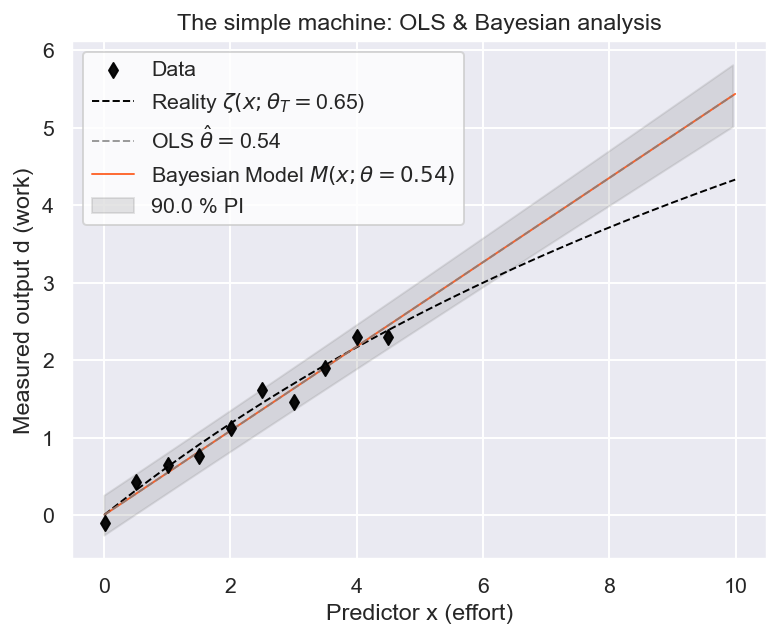

In [21]:
plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
ols='OLS'
plt.plot(Xpredict, ols_prediction.T, color='gray',linewidth=1,
         label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}',alpha=0.8,linestyle='--',zorder=10);
plt.plot(Xreality,model(Xreality,theta=marginal_theta.mean().flatten()),
         label=r'Bayesian Model $M(x;\theta=%.2f)$'%marginal_theta.mean().flatten()[0],
         color='orangered',linewidth=1,alpha=0.8);

plt.fill_between(Xpredict,ols_PI_prediction_L[0].T,ols_PI_prediction_U[0].T,alpha=0.2,color='gray',
                 label=f'{100*(1-CI_alpha):<5.1f}% PI');


plt.xlabel(f'Predictor x (effort)');
plt.ylabel(f'Measured output d (work)');
plt.legend(facecolor='white');
plt.title('The simple machine: OLS & Bayesian analysis');

#### The posterior predictive

In the cell below you can select a new predictor value $x$ outside the measurement domain and compare the model value with reality.

<>:47: SyntaxWarning: invalid escape sequence '\z'
<>:50: SyntaxWarning: invalid escape sequence '\^'
<>:47: SyntaxWarning: invalid escape sequence '\z'
<>:50: SyntaxWarning: invalid escape sequence '\^'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/1600532860.py:47: SyntaxWarning: invalid escape sequence '\z'
  label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/1600532860.py:50: SyntaxWarning: invalid escape sequence '\^'
  label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}',alpha=0.8,linestyle='--',zorder=10);


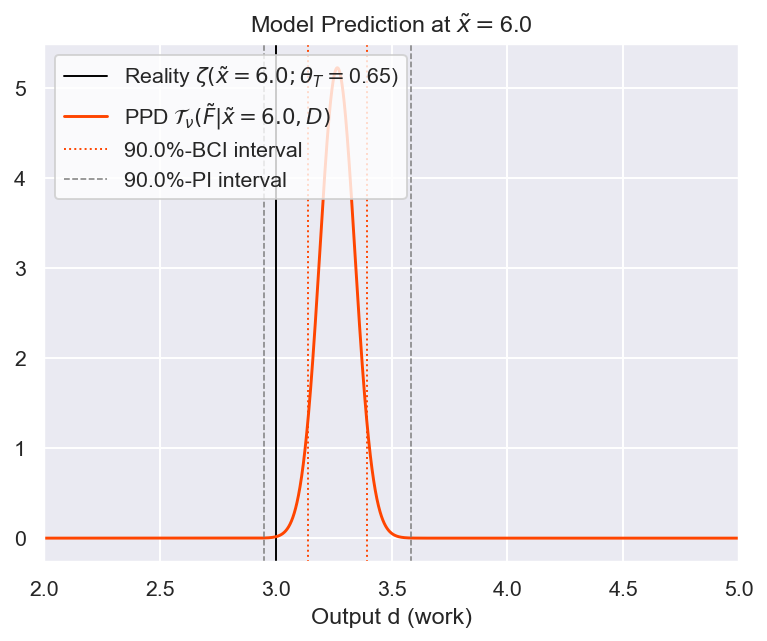

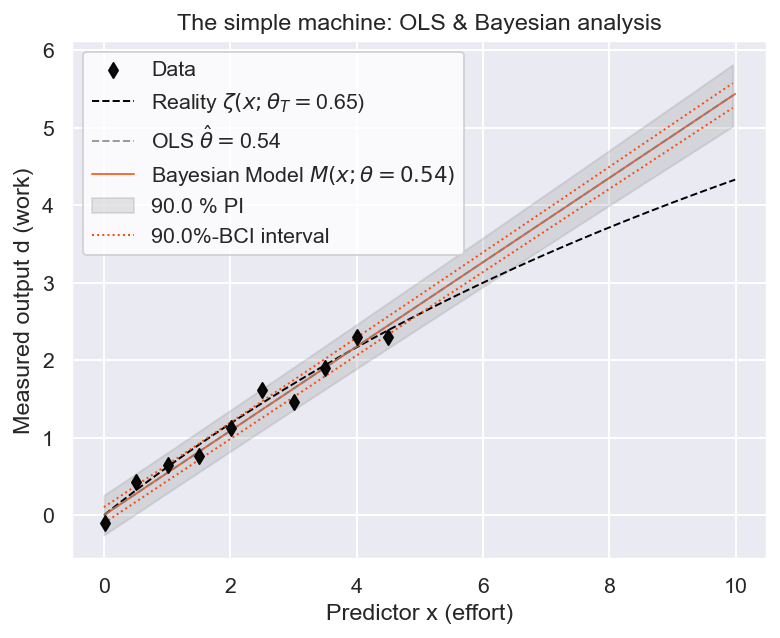

In [22]:
# pick a new predictor value
Xnew = np.array([6])
#setup the design matrix, which is trivial for our model

# evaluate the model at the theta marginal MAP
F_hat = model(Xnew,theta=mu)
F_true = reality(Xnew,theta=theta_T)
plt.axvline(F_true,color='black',linestyle='-',linewidth=1.0,
            label=r'Reality $\zeta(\tilde{x}=%.1f;\theta_T=$%.2f)'%(Xnew[0],theta_T))

Sigma_new = (beta/alpha)*(1+Xnew*Sigma*Xnew.T);
ppd, _ = t_distribution(2 * alpha, F_hat, Sigma_new);

ppd_vals = np.arange(2,model(Xnew[0],theta = ols_theta.flatten()[0])+2,0.001)
F_ppd = ppd.pdf(ppd_vals)[0]
F_bci_interval = ppd.interval(confidence=bci)
plt.plot(ppd_vals,F_ppd,color='orangered',label=r'PPD $\mathcal{T}_{\nu}(\tilde{F}|\tilde{x}=%.1f,D)$'%Xnew[0]);
plt.axvline(F_bci_interval[0],color='orangered',linestyle=':',linewidth=1.0,label=f'{bci*100}%-BCI interval');
plt.axvline(F_bci_interval[1],color='orangered',linestyle=':',linewidth=1.0)

ols_var_PI = np.diag(ols_s2*(np.eye(len(Xnew)) + Xnew*ols_cov*Xnew))
# prediction interval
ols_PI_L = model(Xnew,theta = ols_theta) - np.sqrt(ols_var_PI)*t_nu
ols_PI_U = model(Xnew,theta = ols_theta) + np.sqrt(ols_var_PI)*t_nu

plt.axvline(ols_PI_L,color='gray',linestyle='--',linewidth=0.8,label=f'{bci*100}%-PI interval');
plt.axvline(ols_PI_U,color='gray',linestyle='--',linewidth=0.8)

plt.xlim(2.0,5.0);
plt.title('Model Prediction at $\\tilde{x}=$%.1f'%Xnew[0])
plt.xlabel('Output d (work)')
plt.legend(facecolor='white',loc='upper left');

Phi = Xpredict.reshape(-1,1)
Sigma_new = (beta/alpha)*(np.eye(len(Xpredict))+Phi@Sigma@Phi.T);
ppd, _ = t_distribution(2 * alpha, model(Xpredict,theta=mu), np.diag(Sigma_new));
F_bci_lo = ppd.interval(confidence=bci)[0];
F_bci_hi = ppd.interval(confidence=bci)[1];

#plt.tight_layout()
#plt.savefig('./ppd_informative.pdf')     

fig2 = plt.figure();

plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
ols='OLS'
plt.plot(Xpredict, ols_prediction.T, color='gray',linewidth=1,
         label=f'OLS $\^\\theta=${ols_theta[0][0]:.2f}',alpha=0.8,linestyle='--',zorder=10);
plt.plot(Xreality,model(Xreality,theta=marginal_theta.mean().flatten()),
         label=r'Bayesian Model $M(x;\theta=%.2f)$'%marginal_theta.mean().flatten()[0],
         color='orangered',linewidth=1,alpha=0.8);
plt.fill_between(Xpredict,ols_PI_prediction_L[0].T,ols_PI_prediction_U[0].T,alpha=0.2,color='gray',
                 label=f'{100*(1-CI_alpha):<5.1f}% PI');
plt.plot(Xpredict,F_bci_lo.T, color='orangered',linewidth=1.0,linestyle=':',label=f'{bci*100}%-BCI interval');
plt.plot(Xpredict,F_bci_hi.T, color='orangered',linewidth=1.0,linestyle=':');
plt.legend(facecolor='white');
plt.xlabel(f'Predictor x (effort)');
plt.ylabel(f'Measured output d (work)');
plt.title('The simple machine: OLS & Bayesian analysis');
#plt.tight_layout()
#plt.savefig('./ppd_informative_plot.pdf')

# Markov Chain Monte Carlo sampling of the parameter posterior

We will use MCMC to sample the logarithm of the posterior, i.e.

\begin{equation}
\log[p(\boldsymbol \theta,\sigma^2 | \boldsymbol{\mathcal{D}})] = \log[p(\boldsymbol{\mathcal{D}}|\boldsymbol \theta,\sigma^2)] + \log[p(\boldsymbol \theta,\sigma^2)] - \log[ p(\boldsymbol{\mathcal{D}})].
\end{equation}

For parameter estimation we only need to evaluate the log-likelihood and the log-prior. The log of the marginal likelihood is an overall normalization constant that is of less importance to us right now. It will return when we discuss model comparison.

\begin{equation}
\log[p(\boldsymbol{\mathcal{D}}|\boldsymbol \theta,\sigma^2)] \propto -\frac{N_d}{2}\log(\sigma^2)  -\frac{1}{2}\frac{(\boldsymbol{\mathcal{D}} - \boldsymbol{\Phi}\boldsymbol\theta)^T(\boldsymbol{\mathcal{D}} - \boldsymbol{\Phi}\boldsymbol\theta)}{\sigma^2} 
\end{equation}
\begin{equation}
\log[p(\boldsymbol \theta,\sigma^2)] \propto \log[\mathcal{N}(\boldsymbol \theta| \mathbf{\mu}_0,\sigma^2 \boldsymbol \Sigma_0)] + \log[\mathcal{IG}(\sigma^2|\alpha_0,\beta_0)]
\end{equation}

## Infer $\theta$ and $\sigma^2$ without a model discrepancy term
Below, we use the emcee package to do MCMC and sample the posteriors we also obtained analytically above. This enables use to make learn about the MCMC sampling of these particular posteriors and provides a benchmark to eliminate bugs in our python code.

In [23]:
# MCMC evaluation of the Bayesian posterior for theta and sigma
# par: 0 theta, 1 sigma, 

def log_likelihood(par, x, y):
    mu,sig2=par
    model = x*mu
    n = len(y)
    return -0.5*(np.sum((y-model)**2/sig2)) - (n/2)*np.log(sig2)

def log_prior(par):
    mu,sig2=par
    #
    # uninformative (this is when OLS and Bayes coincides...)
    #
    #lp = np.log(1/sig2)
    #
    # OR informative
    #
    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)   
    log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
    lp = log_IG+log_N
    
    return lp

def log_posterior(par,x,y):
    lp = log_prior(par)
    #lp = np.where(np.isnan(lp),-np.inf,lp)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(par, x, y)

    return ll + lp

We will employ the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC). In this course we will rely on the Python implementation called 'emcee'. For a detailed presentation of this algorithm and the Python package, see https://arxiv.org/abs/1202.3665

Basically a collection of nwalkers will traverse the ndim paramater space in a particular way that fulfills the MCMC requirement of detailed balance to produce a unique equilibrium distribution that is reached in the limit of a large number of computation steps that is also independent of the initial conditions.

In [24]:
ndim, nwalkers = 2, 20
start_pos = [1.0,0.0004] + [1e-2,1e-5]*np.random.randn(nwalkers, ndim)

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Xmeasure, Ydata))
sampler.run_mcmc(start_pos, 2000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/3703763962.py:20: RuntimeWarning: invalid value encountered in sqrt
  log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
100%|██████████| 2000/2000 [00:03<00:00, 563.72it/s]


In [26]:
def simple_mcmc_analysis(sampler, par, label, burn_in, chain_from_file=False):

    if not chain_from_file:
        print(f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples 
    
    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(discard=burn_in,thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')

    fig1 = plt.figure();
    plt.plot(flat_mcmc_samples[:,par],color='gray',alpha=0.7)
    plt.xlabel('Sample');
    plt.ylabel(label)
    plt.xlim(0,len(flat_mcmc_samples));

    return flat_mcmc_samples

Mean acceptance fraction: 0.703
Discarding 2000 steps as burn-in
Chain length:38000


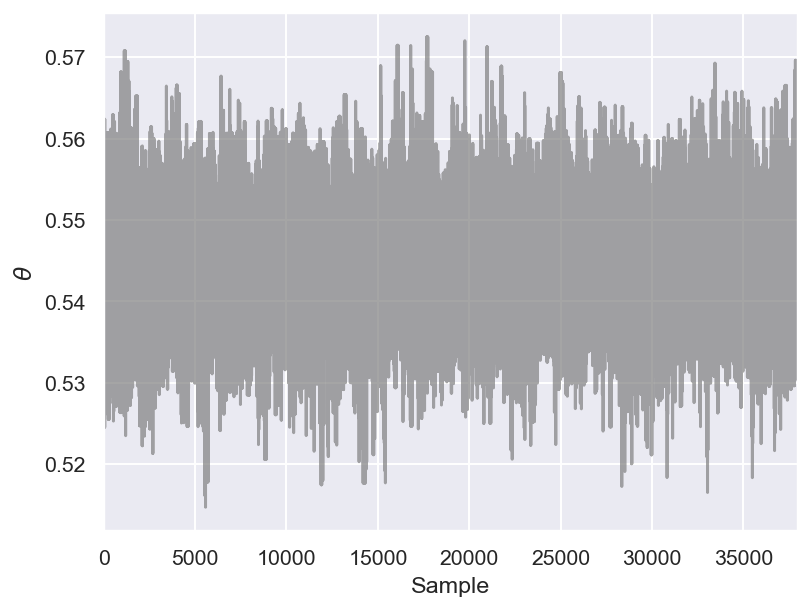

In [27]:
flat_mcmc_samples = simple_mcmc_analysis(sampler, par=0, label=f'$\\theta$', burn_in=100)

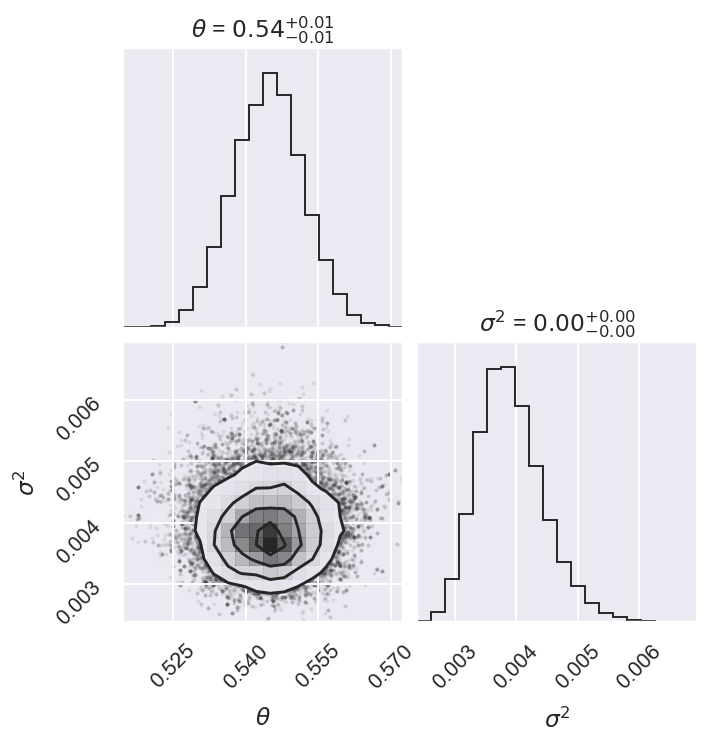

In [28]:
fig = corner.corner(flat_mcmc_samples,labels=[r"$\theta$", r"$\sigma^2$"],show_titles=True);

With a sufficiently long series (chain) of MCMC samples of $\theta$ and $\sigma^2$ we should have a set of values that approximates the posterior $p(\boldsymbol \theta,\sigma^2 | \boldsymbol{\mathcal{D}})$ rather well. 

Below, we marginalize the MCMC chain to the $\theta$ and $\sigma^2$ axes and compare with the analytical results from above. If we employ the sample data and prior, the MCMC histograms should follow the analytical results of the linear model. 

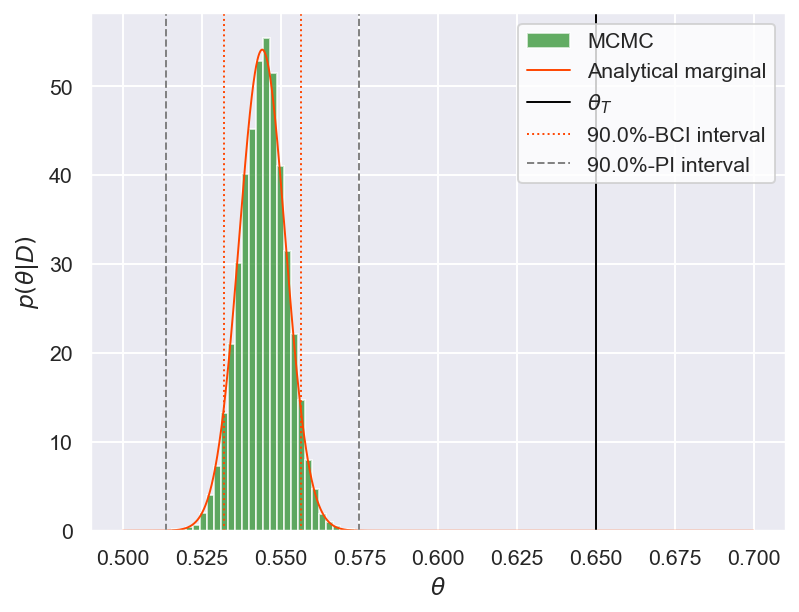

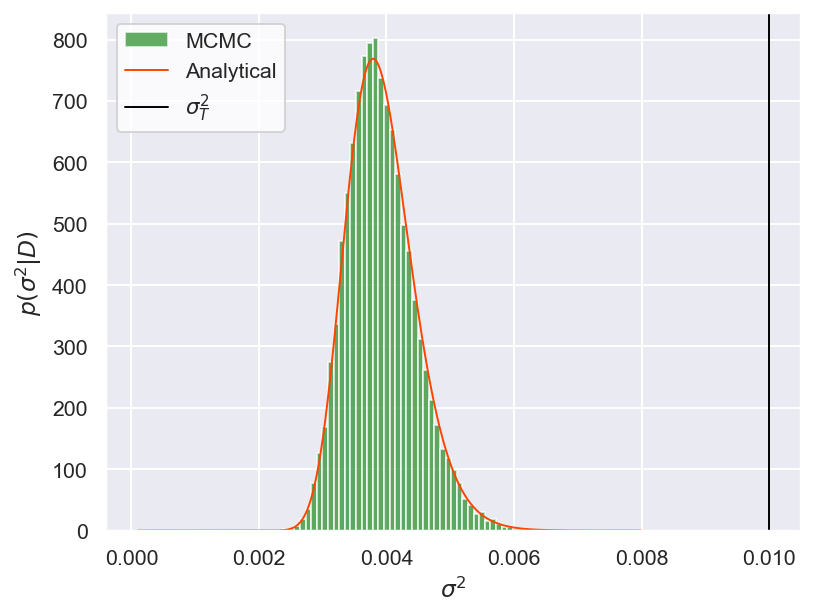

In [29]:
fig1 = plt.figure();
theta_plot_vals=np.arange(0.50,0.70,0.0001)
hist_theta = plt.hist(flat_mcmc_samples[:,0],bins=90,range=[0.50,0.70],color='forestgreen',alpha=0.7,density=True,label='MCMC');
plt.xlabel(f'$\\theta$')
plt.ylabel(f'$p(\\theta|D)$');
plt.plot(theta_plot_vals,marginal_theta.pdf(theta_plot_vals)[0],lw=1,color="orangered",label='Analytical marginal');
plt.axvline(theta_T,color='black',linestyle='-',linewidth=1.0,label=f'$\\theta_T$');
plt.axvline(theta_bci_interval[0],color='orangered',linestyle=':',linewidth=1.0,label=f'{bci*100}%-BCI interval');
plt.axvline(theta_bci_interval[1],color='orangered',linestyle=':',linewidth=1.0)
plt.axvline(CI_low[0][0],color='gray',linestyle='--',linewidth=1.0,label=f'{bci*100}%-PI interval');
plt.axvline(CI_high,color='gray',linestyle='--',linewidth=1.0)
plt.legend(facecolor='white');

fig2 = plt.figure();
sigma2_plot_vals=np.arange(0.0001,0.008,0.00001)
hist_theta = plt.hist(flat_mcmc_samples[:,1],bins=90,range=[0.0001,0.008],color='forestgreen',alpha=0.7,density=True,label='MCMC');
plt.xlabel(f'$\\sigma^2$')
plt.ylabel(f'$p(\\sigma^2|D)$');
plt.plot(sigma2_plot_vals,marginal_sigma2.pdf(sigma2_plot_vals),lw=1,color="orangered",label='Analytical');
plt.axvline(sigma2_T,color='black',linestyle='-',linewidth=1.0,label=f'$\\sigma^2_T$');
plt.legend(facecolor='white');

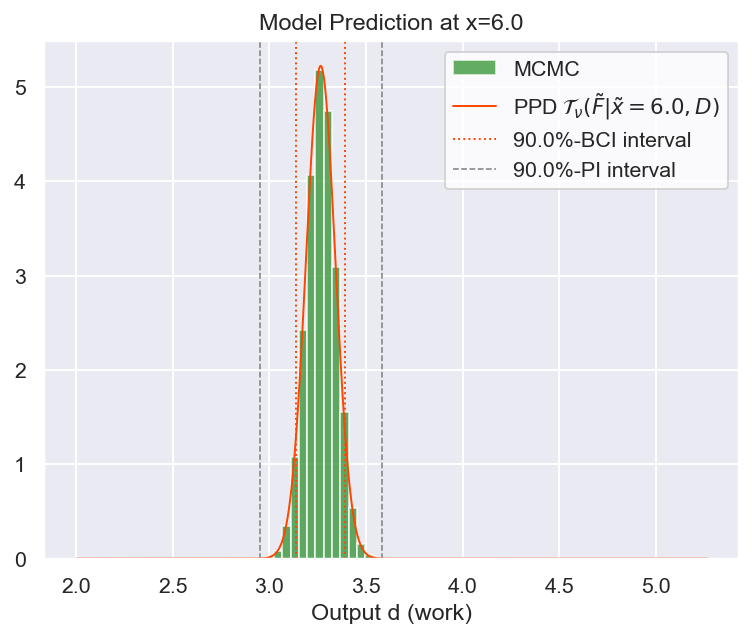

In [30]:
ppd_hist = model(Xnew,theta = flat_mcmc_samples[:,0]) + np.random.normal(0,np.sqrt(flat_mcmc_samples[:,1]))
plt.hist(ppd_hist,density=True,bins=15,color='forestgreen',alpha=0.7,label='MCMC');
plt.plot(ppd_vals,F_ppd,color='orangered',lw=1,label=r'PPD $\mathcal{T}_{\nu}(\tilde{F}|\tilde{x}=%.1f,D)$'%Xnew[0]);
plt.axvline(F_bci_interval[0],color='orangered',linestyle=':',linewidth=1.0,label=f'{bci*100}%-BCI interval');
plt.axvline(F_bci_interval[1],color='orangered',linestyle=':',linewidth=1.0)
plt.axvline(ols_PI_L,color='gray',linestyle='--',linewidth=0.8,label=f'{bci*100}%-PI interval');
plt.axvline(ols_PI_U,color='gray',linestyle='--',linewidth=0.8)
plt.title('Model Prediction at x=%.1f'%Xnew[0])
plt.xlabel('Output d (work)')
plt.legend(facecolor='white');

# Incorporating a model discrepancy term

MCMC will not remedy the problem of a missing model-discrepancy term. So, lets finally get to the point where we include $\delta(x)$.

We do not know much about $\delta(x)$ and will model it in a probabilistic way using a Gaussian Process.

This means that we will have a tailored stochastic process to represent $\delta(x)$. In our example this means that given e.g. two values $x_1$ and $x_2$ for the predictor, the GP will provide a normally distributed value for $\delta(x_1)$ and $\delta(x_2)$ that are also correlated with each other. The strength (or scale) of this correlation is determined by a typical distance called the correlation length. In practice, we will specify prior pdf:s for the correlation length $\ell_{GP}$ and the variance $\sigma^{2}_{GP}$. This means that our model now lives in a 4-dimensional parameter space $[\theta,\sigma^2,\ell_{GP},\sigma^2_{GP}]$, where the latter two parameters govern the model discrepancy term, and we will extract a 4-dimensional posterior distribution using MCMC. 

Intuitively, the model discrepancy will (hopefully) 'fix' part of the problem with our model, in the sense that we will obtain a more realistic inference of  $\theta$, or at least induce more realistic credibility intervals. 

There is unfortunatly no free lunch. You will experience that the inferred pdf for $\theta$ becomes more realistic as we assign more realistic priors to the model discrepancy. But we will start with a vanilla GP and not much else.

## Using a "home-made" GP

You can read more about GPs in the lecture notes. We will start off with coding most things from scratch. Towards the end you will also find some code for constructing GPs using the Python package 'GPy'.

We will use a GP with a squared exponential kernel to model the correlations, i.e.

\begin{equation}
k(x_1,x_2) = \sigma^2_{GP} \exp\left\{ -\frac{1}{2\ell^2_{GP}} (x_1-x_2)^2 \right\}
\end{equation}

We will utilize the built-in functionality to take outer products and outer sums in Python when we setup the kernel functions. This is showcased in the next cells.

### 'outer' functionality in Python

In [31]:
# helper function for pretty-printing of matrices
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")  

In [32]:
X1 = np.array([2,4,6]).reshape(-1,1)
# column vector
print(X1.shape)
matprint(X1)
print(f'outer product btw vectors X1 and X1 (ver. 1)')
matA = np.outer(X1,X1)
matprint(matA)
print(f'outer product btw vectors X1 and X1 (ver. 2)')
matA = np.matmul(X1,X1.T)
matprint(matA)
print(f'outer product btw vectors X1 and X1 (ver. 3)')
matA = X1*X1.T
matprint(matA)
print()
print(f'outer product btw vectors X1 and X1 (ver. 4 Python >3.5)')
print(f'used in the cells below')
matA = X1@X1.T
matprint(matA)
print()
print(f'outer sum/difference btw vectors X1 and X1')
print(f'used in the cells below')
matA = np.abs(X1+X1.T)
matprint(matA)

(3, 1)
2  
4  
6  
outer product btw vectors X1 and X1 (ver. 1)
 4   8  12  
 8  16  24  
12  24  36  
outer product btw vectors X1 and X1 (ver. 2)
 4   8  12  
 8  16  24  
12  24  36  
outer product btw vectors X1 and X1 (ver. 3)
 4   8  12  
 8  16  24  
12  24  36  

outer product btw vectors X1 and X1 (ver. 4 Python >3.5)
used in the cells below
 4   8  12  
 8  16  24  
12  24  36  

outer sum/difference btw vectors X1 and X1
used in the cells below
4   6   8  
6   8  10  
8  10  12  


In [33]:
def sqe_kernel(X1, X2, l=1.0, sq_sigma=1.0):
    
    #Squared exponential kernel. 
    return sq_sigma * np.exp(-0.5 / l**2 * np.abs(X1-X2.T)**2)

In [34]:
# GP: zero-mean SQE prior
def gp_prior(x_pred, l=1, sq_sigma=1):
    sigma_xx = sqe_kernel(x_pred, x_pred, l, sq_sigma)
    return np.zeros(x_pred.shape).reshape(-1,1), sigma_xx

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/596599661.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel(f'$f(x) \sim \mathcal{{GP}}$');


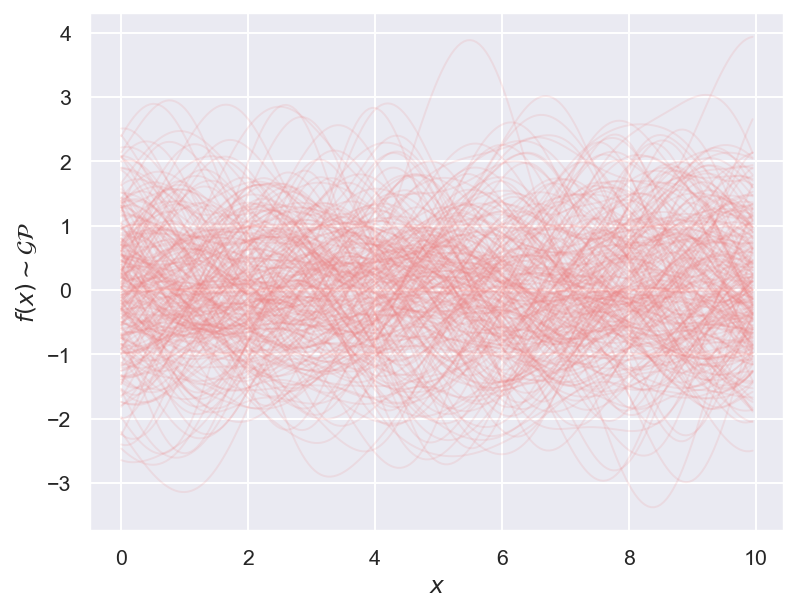

In [35]:
# Finite number of points
X = Xpredict.reshape(-1, 1);

mu, cov = gp_prior(X,l = 1,sq_sigma = 1)

# Draw some samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 250,check_valid='ignore')
for this_sample in samples:
    plt.plot(X,this_sample,color='lightcoral',linewidth=1,alpha=0.15);
    
plt.xlabel(f'$x$');
plt.ylabel(f'$f(x) \sim \mathcal{{GP}}$');
#plt.tight_layout();
#plt.savefig('./GP_SQE.pdf')

## A first attempt to include $\delta(x)$ in the inference of $\theta$

<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_82813/2847631042.py:48: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel(f'$\\delta(x) \sim \mathcal{{GP}}$');


Inverse-gamma hyperprior for GP variance
a_IG_GP = 1.6666666666666663, b_IG_GP = 0.23999999999999996
IG_GP mode = 0.09000000000000001
Gamma hyperprior for GP lengtscale
a_G_GP = 18.0 b_G_GP = 0.16666666666666666
G_GP mode = 102.0
NIG parameter prior
mu0 = [1.] Sigma0 = [[2000.]]
a0 = 49.50505050505045 b0 = 0.12126262626262616


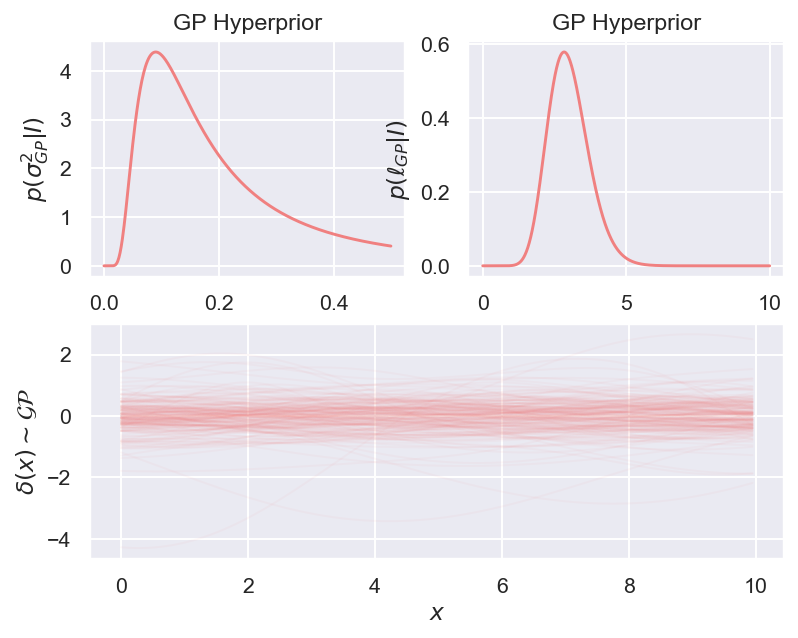

In [36]:
# hyperprior settings
# 

fig = plt.figure()
gs = GridSpec(nrows=2, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
a_IG_GP, b_IG_GP = mean_mode_2_IG_alpha_beta(0.6**2,0.3**2)
print(f'Inverse-gamma hyperprior for GP variance')
print(f'a_IG_GP = {a_IG_GP}, b_IG_GP = {b_IG_GP}')
print(f'IG_GP mode = {b_IG_GP/(a_IG_GP+1)}')
s2_GP_IG, _ = ig_distribution(a_IG_GP, b_IG_GP)
s2_GP_range = np.arange(0,0.5,0.001)
ax0.set_xlabel(f'$\\sigma^2_{{GP}}$')
ax0.set_ylabel(f'$p(\\sigma^2_{{GP}}|I)$')
ax0.set_title(f'GP Hyperprior')
ax0.plot(s2_GP_range,s2_GP_IG.pdf(s2_GP_range),color='lightcoral')

ax1 = fig.add_subplot(gs[0, 1])
a_G_GP, b_G_GP = mean_variance_2_G_alpha_beta(3,0.5)
print(f'Gamma hyperprior for GP lengtscale')
print(f'a_G_GP = {a_G_GP} b_G_GP = {b_G_GP}')
print(f'G_GP mode = {(a_G_GP-1)/(b_G_GP)}')
ell_GP_G, _ = g_distribution(a_G_GP, b_G_GP)
ell_GP_range = np.arange(0,10,0.01)
ax1.set_xlabel(f'$\\ell_{{GP}}$')
ax1.set_ylabel(f'$p(\\ell_{{GP}}|I)$')
ax1.set_title(f'GP Hyperprior')
ax1.plot(ell_GP_range,ell_GP_G.pdf(ell_GP_range),color='lightcoral')

print(f'NIG parameter prior')
print(f'mu0 = {mu0} Sigma0 = {Sigma0}')
print(f'a0 = {a0} b0 = {b0}')

ax2 = fig.add_subplot(gs[1, :])
# Finite number of points
X = Xpredict.reshape(-1, 1);
#hyperprior
for sp in range(0,200,1):
    GP_sigma2 = invgamma.rvs(a=a_IG_GP, scale=b_IG_GP)
    GP_ell  = gamma.rvs(a=a_G_GP,scale=b_G_GP)
    mu, cov = gp_prior(X,l = GP_ell,sq_sigma = GP_sigma2)
    # Draw sample from the prior
    sample = np.random.multivariate_normal(mu.ravel(), cov, 1,check_valid='ignore')
    ax2.plot(X,sample[0],color='lightcoral',linewidth=1,alpha=0.05);
    
ax2.set_xlabel(f'$x$');
ax2.set_ylabel(f'$\\delta(x) \sim \mathcal{{GP}}$');
#plt.tight_layout()
#plt.savefig('./GP_prior.pdf')
plt.show()


In [37]:
# MCMC evaluation of the Bayesian posterior for theta and sigma2
# par: 0 theta, 1 sigma2, 2 sigma2_GP, 3 ell_GP 
#
def log_likelihood(par, x, y):
    theta, sigma2, sigma2_GP, ell_GP=par 
    
    x_ = np.array(x).reshape(-1,1)
    mu, cov = gp_prior(x_,l = ell_GP,sq_sigma = sigma2_GP)

    model = x_*theta + np.random.multivariate_normal(mu.ravel(), cov, 1,check_valid='ignore').T
    n = len(y)
    return -0.5*(np.sum((y-model.T)**2/sigma2)) - (n/2)*np.log(sigma2)

def log_prior(par):
    mu, sig2, GP_sigma2, GP_ell=par 

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)
    log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
    
    log_GP_IG = invgamma.logpdf(GP_sigma2,a=a_IG_GP, scale=b_IG_GP)
    log_GP_G  = gamma.logpdf(GP_ell,a=a_G_GP,scale=b_G_GP)

    lp = log_IG + log_N + log_GP_IG + log_GP_G 
    return lp

def log_posterior(par,x,y):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(par, x, y)
    return ll + lp

In [38]:
ndim, nwalkers = 4, 200
start_pos = [1,0.001,0.02,2.5] + [1e-2,1e-4,1e-3,1e-1]*np.random.randn(nwalkers, ndim)

In [39]:
# Set up the backend to save output to an hdf5 file
filename = "UGP_samples_2024.h5"
# set to True if you want to read a pre-recorded chain
use_existing_chain = True

if use_existing_chain:
    print(f'Reading chain from {filename}')
    sampler_UGP = emcee.backends.HDFBackend(filename)
else:
    print(f'Storing chain in {filename}')
    backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    sampler_UGP = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Xmeasure, Ydata),backend=backend)
    sampler_UGP.run_mcmc(start_pos, 5000, progress=True);

Reading chain from UGP_samples_2024.h5


In [40]:
flat_mcmc_GP_samples = simple_mcmc_analysis(sampler_UGP, par=0, label=f'$\\theta$', burn_in=200, 
                                            chain_from_file=use_existing_chain)

AttributeError: You must run the sampler with 'store == True' before accessing the results

In [ ]:
fig = corner.corner(flat_mcmc_GP_samples,labels=[r"$\theta$", r"$\sigma^2$", r"$\sigma^2_{GP}$", r"$\ell_{GP}$"],show_titles=True);
#plt.savefig('./corner_mcmc_GP_2024.pdf')

### Plot $\theta$ inference with/without GP

In [ ]:
fig1 = plt.figure();
hist_theta = plt.hist(flat_mcmc_samples[:,0],bins=40,range=[0.45,0.70],color='forestgreen',alpha=0.5,density=True,label='w/o $\\delta(x)$');
hist_theta = plt.hist(flat_mcmc_GP_samples[:,0],bins=40,range=[0.45,0.70],color='lightcoral',alpha=0.5,density=True,label='w $\\delta(x)$');

plt.xlabel(f'$\\theta$')
plt.ylabel(f'$p(\\theta|D)$');
plt.legend(facecolor='white');

fig2 = plt.figure();
hist_sigma2 = plt.hist(flat_mcmc_GP_samples[:,1],bins=20,range=[0.0001,0.005],color='lightcoral',alpha=0.5,density=True,label='w $\\delta(x)$');
plt.xlabel(f'$\\sigma^2$')
plt.ylabel(f'$p(\\sigma^2|D)$');
plt.legend(facecolor='white');

### Plot the model and the data

In [ ]:
# draw samples from the MCMC chain
def plot_model(x, model, mcmc_chain,nsamples):
    sample_idx = random.sample(range(0, len(mcmc_chain)), nsamples)
    samples = mcmc_chain[sample_idx]
    print(f'plotting {nsamples} random samples in MCMC chain')
    x = x.reshape(-1,1)
    for sample in samples:
        mu, cov = gp_prior(x,l = sample[3],sq_sigma = sample[2])
        output = model(x,sample[0]) + np.random.normal(0,np.sqrt(sample[1])) +  \
        np.random.multivariate_normal(mu.ravel(), cov, 1,check_valid='ignore').T
        plt.plot(x,output,color='lightcoral',alpha=0.025)
        
    plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
    plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
    plt.legend(facecolor='white')
    plt.xlabel(f'Predictor x (effort)');
    plt.ylabel(f'Measured output d (work)');
    plt.title('The simple machine: Bayesian GP model');

In [ ]:
plot_model(Xpredict,model,flat_mcmc_GP_samples,nsamples=500)

## Include constrained $\delta(x)$ (constraint $\delta(0)=0$)

In [ ]:
# GP posterior: GP prior confronted with (noiseless) data {x_data,y_data}
def gp_posterior(x_pred, x_data, y_data, l=1.0, sq_sigma=1.0):
    sigma_xx = sqe_kernel(x_pred, x_pred, l, sq_sigma);
    sigma_xd = sqe_kernel(x_pred, x_data, l, sq_sigma);
    sigma_dx = sqe_kernel(x_data, x_pred, l, sq_sigma);
    sigma_dd = sqe_kernel(x_data, x_data, l, sq_sigma);
    # note that we often have sigma_dx = sigma_xd.T etc but for clarity
    # we stick to a an implementation without optimizations 
    mu = (sigma_xd@np.linalg.inv(sigma_dd))@y_data
    cov = sigma_xx - sigma_xd@np.linalg.inv(sigma_dd)@sigma_dx
    return mu.reshape(-1,1), cov

In [ ]:
# Finite number of points
X = Xpredict.reshape(-1, 1);

# some data about the function we are modelling with the GP
# i.e. pairs [x_1,y_1], [x_2,y_2], ... with known values for x_i and y_i
xd = np.array([[0]]);
yd = np.array([[0]]);

mu, cov = gp_posterior(X, xd, yd,l = 4,sq_sigma = 0.03**2)

# Draw some samples from the GP posterior
samples = np.random.multivariate_normal(mu.ravel(), cov, 250,check_valid='ignore')
for this_sample in samples:
    plt.plot(X,this_sample,color='dodgerblue',linewidth=1,alpha=0.05);
    
plt.xlabel(f'$x$');
plt.ylabel(f'$\mathcal{{GP}}(x)$');

# the diagonal of the GP covariance matrix provides us with exact values for the GP variance 
#fig2 = plt.figure();
plt.plot(X,mu,label=f'$\\mu(x)$',color='dodgerblue',lw=1);
plt.fill_between(X.ravel(),mu.ravel()-np.sqrt(np.diag(cov)).ravel(),
                 mu.ravel()+np.sqrt(np.diag(cov)).ravel(),alpha=0.3,label=f"1 $\\sigma(x)$ band",color='dodgerblue');
plt.xlabel(f'$x$');
plt.ylabel(f'$\mathcal{{GP}}(x)$');
plt.legend(facecolor='white');

We know that the model discrepancy should vanish for $x=0$; that is we should constrain the GP with data $[0,0]$. This is the only new piece of information that we include. Everything else (priors, hyperpriors, etc) remain unchanged 

In [ ]:
# MCMC evaluation of the Bayesian posterior for theta and sigma2
# par: 0 theta, 1 sigma2, 2 sigma2_GP, 3 ell_GP 
#

xd = np.array([[0]]);
yd = np.array([[0]]);

def log_likelihood(par, x, y):
    theta, sigma2, sigma2_GP, ell_GP=par 
    
    x_ = np.array(x).reshape(-1,1)
    mu, cov = gp_posterior(x_, xd, yd,l = ell_GP,sq_sigma = sigma2_GP)

    model = x_*theta + np.random.multivariate_normal(mu.ravel(), cov, 1, check_valid='ignore').T
    n = len(y)
    return -0.5*(np.sum((y-model.T)**2/sigma2)) - (n/2)*np.log(sigma2)

def log_prior(par):
    mu, sig2, GP_sigma2, GP_ell=par 

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)
    log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
    
    log_GP_IG = invgamma.logpdf(GP_sigma2,a=a_IG_GP, scale=b_IG_GP)
    log_GP_G  = gamma.logpdf(GP_ell,a=a_G_GP,scale=b_G_GP)

    lp = log_IG + log_N + log_GP_IG + log_GP_G 
    return lp

def log_posterior(par,x,y):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(par, x, y)
    return ll + lp

In [ ]:
ndim, nwalkers = 4, 200
start_pos = [1,0.001,0.02,2.5] + [1e-2,1e-4,1e-3,1e-1]*np.random.randn(nwalkers, ndim)

In [ ]:
# Set up the backend to save output to an hdf5 file
filename = "CGP_samples_2024.h5"
# set to True if you want to read a pre-recorded chain
use_existing_chain = True
if use_existing_chain:
    print(f'Reading chain from {filename}')
    sampler_CGP = emcee.backends.HDFBackend(filename)
else:
    print(f'Storing chain in {filename}')
    backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    sampler_CGP = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Xmeasure, Ydata),backend=backend)
    sampler_CGP.run_mcmc(start_pos, 4000, progress=True);


In [ ]:
flat_mcmc_CGP_samples = simple_mcmc_analysis(sampler_CGP, par=0, label=f'$\\theta$', burn_in=100,
                                             chain_from_file=use_existing_chain)

In [ ]:
fig = corner.corner(flat_mcmc_CGP_samples,
                    labels=[r"$\theta$", r"$\sigma^2$", r"$\sigma^2_{GP}$", r"$\ell_{GP}$"],show_titles=True);

In [ ]:
fig1 = plt.figure();
theta_plot_vals=np.arange(0.40,0.75,0.0001)
hist_theta = plt.hist(flat_mcmc_samples[:,0],bins=30,range=[0.40,0.75],color='forestgreen',alpha=0.5,density=True,label='w/o $\\delta(x)$');
hist_theta = plt.hist(flat_mcmc_CGP_samples[:,0],bins=30,range=[0.40,0.75],color='dodgerblue',alpha=0.75,density=True,label='w $\\delta(x)$ $(\\delta(0)=0)$');
hist_theta = plt.hist(flat_mcmc_GP_samples[:,0],bins=30,range=[0.40,0.75],color='lightcoral',alpha=0.55,density=True,label='w $\\delta(x)$');

plt.xlabel(f'$\\theta$')
plt.ylabel(f'$p(\\theta|D)$');
plt.legend(facecolor='white');


fig2 = plt.figure();
hist_sigma2 = plt.hist(flat_mcmc_CGP_samples[:,1],bins=20,range=[0.0001,0.006],color='dodgerblue',alpha=0.5,density=True,label='w $\\delta(x)$');
plt.xlabel(f'$\\sigma^2$')
plt.ylabel(f'$p(\\sigma^2|D)$');
plt.legend(facecolor='white');

In [ ]:
def plot_constrained_model(x, model, mcmc_chain,nsamples):
    sample_idx = random.sample(range(0, len(mcmc_chain)), nsamples)
    samples = mcmc_chain[sample_idx]
    print(f'plotting {nsamples} random samples in MCMC chain')
    x = x.reshape(-1,1)
    for sample in samples:
        mu, cov = gp_posterior(x,xd,yd,l = sample[3],sq_sigma = sample[2])
        output = model(x,sample[0]) + np.random.normal(0,np.sqrt(sample[1])) +  \
        np.random.multivariate_normal(mu.ravel(), cov, 1, check_valid='ignore').T
        plt.plot(x,output,color='dodgerblue',alpha=0.025)
        
    plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
    plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
    plt.legend(facecolor='white')
    plt.xlabel(f'Predictor x (effort)');
    plt.ylabel(f'Measured output d (work)');
    plt.title('The simple machine: Bayesian GP model');

In [ ]:
plot_constrained_model(Xpredict,model,flat_mcmc_CGP_samples,nsamples=500)

## Include constrained $\delta(x)$ (constraint $\delta(0)=0$ & $\delta'(x) < 0$)

Assume that we expect that friction plays an important role. A characteristic of friction is that it will increase slowly and smoothly as the effort $x$ increases. Thus, $\delta(x)$ is a smooth and monotonically decreasing function. 

In [ ]:
def d10_sqe_kernel(X1, X2, l=1.0, sq_sigma=1.0):
    #First derivative wrt X1: Squared exponential kernel. 
    return -(1/l**2) * (X1-X2.T) * sqe_kernel(X1, X2, l, sq_sigma)

def d01_sqe_kernel(X1, X2, l=1.0, sq_sigma=1.0):
    #First derivative wrt X2: Squared exponential kernel. 
    return (1/l**2) * (X1-X2.T) * sqe_kernel(X1, X2, l, sq_sigma)

def dd_sqe_kernel(X1, X2, l=1.0, sq_sigma=1.0):
    #Second derivative wrt X1X2: Squared exponential kernel. 
    #Identical to derivative wrt X2X1
    return (1/l**2) * sqe_kernel(X1, X2, l, sq_sigma) - (1/l**4) * (X1-X2.T)**2 * sqe_kernel(X1, X2, l, sq_sigma)

#[GP(0,cov),dGP(0,cov)]
def d_gp_prior(x_pred, l=1, sq_sigma=1):
    sigma_xx    = sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xx_01 = d01_sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xx_10 = d10_sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xx_11 = dd_sqe_kernel(x_pred, x_pred, l, sq_sigma)
    cov_R1 = np.concatenate((sigma_xx,sigma_xx_01),axis=1)
    cov_R2 = np.concatenate((sigma_xx_10,sigma_xx_11),axis=1)
    cov = np.concatenate((cov_R1,cov_R2))
    return np.zeros(2*len(x_pred)).reshape(-1,1), cov

def d_gp_posterior_function_conditional(x_pred, x_data, y_data, l=1, sq_sigma=1):
    sigma_xx = sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xd = sqe_kernel(x_pred, x_data, l, sq_sigma)
    sigma_dx = sqe_kernel(x_data, x_pred, l, sq_sigma)
    sigma_dd = sqe_kernel(x_data, x_data, l, sq_sigma);
    Lambda = np.linalg.inv(sigma_dd)
    
    sigma_xx_01 = d01_sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xx_10 = d10_sqe_kernel(x_pred, x_pred, l, sq_sigma)
    sigma_xx_11 = dd_sqe_kernel(x_pred, x_pred, l, sq_sigma)    
    
    sigma_xd_10 = d10_sqe_kernel(x_pred, x_data, l, sq_sigma)
    sigma_dx_01 = d01_sqe_kernel(x_data, x_pred, l, sq_sigma)
    
    bar_sigma_00 = sigma_xx - (sigma_xd@Lambda)@sigma_dx
    bar_sigma_01 = sigma_xx_01 - (sigma_xd@Lambda)@sigma_dx_01
    bar_sigma_10 = sigma_xx_10 - (sigma_xd_10@Lambda)@sigma_dx
    bar_sigma_11 = sigma_xx_11 - (sigma_xd_10@Lambda)@sigma_dx_01
    cov_R1 = np.concatenate((bar_sigma_00,bar_sigma_01),axis=1)
    cov_R2 = np.concatenate((bar_sigma_10,bar_sigma_11),axis=1)
    bar_sigma = cov = np.concatenate((cov_R1,cov_R2))
    
    mu = (sigma_xd@Lambda)@y_data
    mu_1 = (sigma_xd_10@Lambda)@y_data
    bar_mu = np.concatenate((mu,mu_1))
    return bar_mu, bar_sigma

def d_gp_posterior_derivative_conditional(x_pred, x_data, y_data, l=1, sq_sigma=1):
    
    sigma_xd_01 = d01_sqe_kernel(x_pred, x_data, l, sq_sigma)
    sigma_dx_10 = d10_sqe_kernel(x_data, x_pred, l, sq_sigma)
    sigma_dd_11 = dd_sqe_kernel(x_data, x_data, l, sq_sigma)
    Lambda = np.linalg.inv(sigma_dd_11)
    
    sigma_xx = sqe_kernel(x_pred, x_pred, l, sq_sigma)
    
    bar_mu = sigma_xd_01@Lambda@y_data
    bar_sigma = sigma_xx - sigma_xd_01@Lambda@sigma_dx_10
    
    return bar_mu, bar_sigma 

def d_gp_posterior_functional_and_derivative_conditional(x_pred, xy_data, y_data, xdy_data, dy_data, l=1, sq_sigma=1):
    
    y = np.concatenate((y_data,dy_data))
    
    sigma_xx        = sqe_kernel(x_pred , x_pred , l, sq_sigma)
    sigma_xxy       = sqe_kernel(x_pred , xy_data, l, sq_sigma)
    sigma_xxdy_01   = d01_sqe_kernel(x_pred  , xdy_data, l, sq_sigma)
    
    sigma_xyx       = sqe_kernel(xy_data, x_pred , l, sq_sigma)
    sigma_xyxy      = sqe_kernel(xy_data, xy_data, l, sq_sigma)
    sigma_xyxdy_01  = d01_sqe_kernel(xy_data , xdy_data, l, sq_sigma)
    
    sigma_xdyx_10   = d10_sqe_kernel(xdy_data, x_pred  , l, sq_sigma)
    sigma_xdyxy_10  = d10_sqe_kernel(xdy_data, xy_data , l, sq_sigma) 
    sigma_xdyxdy_11 = dd_sqe_kernel(xdy_data, xdy_data, l, sq_sigma)
    
    S11 = sigma_xx
    S12 = np.concatenate((sigma_xxy,sigma_xxdy_01),axis=1)
    S21 = np.concatenate((sigma_xyx,sigma_xdyx_10))
    
    R1 = np.concatenate((sigma_xyxy,sigma_xyxdy_01),axis=1) 
    R2 = np.concatenate((sigma_xdyxy_10,sigma_xdyxdy_11),axis=1)
    S22 = np.concatenate((R1,R2))
    Lambda = np.linalg.inv(S22)
    
    bar_mu = S12@Lambda@y
    bar_sigma = S11 - S12@Lambda@S21
    
    return bar_mu, bar_sigma

In [ ]:
# Finite number of points
X = Xpredict.reshape(-1, 1);

mu, cov = d_gp_prior(X,l = 1,sq_sigma = 1**2)

sample = np.random.multivariate_normal(mu.ravel(), cov, 1,check_valid='ignore')
f,df = np.split(sample[0],2)
plt.plot(X,f,color='purple',linewidth=1,alpha=0.5,label='f(x)');
plt.plot(X,df,color='purple',linewidth=1,alpha=0.5,label=f'$\\frac{{df}}{{dx}}$',linestyle='--');
plt.legend();
plt.xlabel(f'x');
plt.ylabel(f'$\\mathcal{{GP}}$');
#plt.tight_layout();
#plt.savefig('./f_df.pdf')

In [ ]:
# Finite number of points
fig = plt.figure()
gs = GridSpec(nrows=2, ncols=1)

ax0 = fig.add_subplot(gs[0, 0])

np.random.seed(1)
X = Xpredict.reshape(-1,1)

xd = np.array([[0],[2],[7]]);
yd = np.array([[0],[-3],[4]]);
bar_mu, bar_cov = d_gp_posterior_function_conditional(X,xd,yd,l=1,sq_sigma=1)

# Draw some samples from the prior
samples = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 250, check_valid='ignore')
for this_sample in samples:
    bar_f,d_bar_f = np.split(this_sample,2)
    ax0.plot(X,bar_f,color='purple',linewidth=1,alpha=0.15);
    ax0.plot(X,d_bar_f,color='slateblue',linewidth=1,alpha=0.05);
#plt.legend();
ax0.set_ylabel(f'$\mathcal{{GP}}(x)$');


ax1 = fig.add_subplot(gs[1, 0])


# the diagonal of the GP covariance matrix provides us with exact values for the GP variance 
bar_mu_f, bar_mu_df = np.split(bar_mu.ravel(),2)
bar_cov_f, bar_cov_df = np.split(np.diag(bar_cov),2)
ax1.plot(X.ravel(),bar_mu_f,color='purple',lw=1);
ax1.fill_between(X.ravel(),bar_mu_f-np.sqrt(bar_cov_f),
                 bar_mu_f+np.sqrt(bar_cov_f),alpha=0.3,label=f"$f$",color='purple');
ax1.plot(X.ravel(),bar_mu_df,color='slateblue',lw=1);
ax1.fill_between(X.ravel(),bar_mu_df-np.sqrt(bar_cov_df),
                 bar_mu_df+np.sqrt(bar_cov_df),alpha=0.3,label=f"$f\'$",color='slateblue');
ax1.set_xlabel(f'$x$');
ax1.set_ylabel(f'$\mathcal{{GP}}(x)$');
ax1.legend(facecolor='white');
#plt.tight_layout();
#plt.savefig('./f_df_conditioned.pdf')

In the following cells we test a GP conditioned on derivative information (although we do not use this approach)

In [ ]:
# Finite number of points
fig = plt.figure()
gs = GridSpec(nrows=2, ncols=1)

ax0 = fig.add_subplot(gs[0, 0])

np.random.seed(1)
X = Xpredict.reshape(-1,1)

xd = np.array([[0],[6]]);
yd = np.array([[1],[-2]]);

bar_mu, bar_cov = d_gp_posterior_derivative_conditional(X,xd,yd,l=1,sq_sigma=1)

# Draw some samples from the prior
samples = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 250, check_valid='ignore')
for this_sample in samples:
    ax0.plot(X,this_sample,color='purple',linewidth=1,alpha=0.15);
#plt.legend();
ax0.set_ylabel(f'$\mathcal{{GP}}(x)$');
ax1 = fig.add_subplot(gs[1, 0])

# the diagonal of the GP covariance matrix provides us with exact values for the GP variance 
bar_mu_f = bar_mu.ravel()
bar_cov_f = np.diag(bar_cov)
ax1.plot(X.ravel(),bar_mu_f,color='purple',lw=1);
ax1.fill_between(X.ravel(),bar_mu_f-np.sqrt(bar_cov_f),
                 bar_mu_f+np.sqrt(bar_cov_f),alpha=0.3,label=f"$f$",color='purple');
ax1.set_xlabel(f'$x$');
ax1.set_ylabel(f'$\mathcal{{GP}}(x)$');
ax1.legend(facecolor='white');
#plt.tight_layout();
#plt.savefig('./f_df_conditioned.pdf')

In the following cells we test a GP conditioned on function and derivative information (although we do not use this approach)

In [ ]:
# Finite number of points
fig = plt.figure()
gs = GridSpec(nrows=2, ncols=1)

ax0 = fig.add_subplot(gs[0, 0])

np.random.seed(1)
X = Xpredict.reshape(-1,1)

xd = np.array([[0],[2],[4]]);
yd = np.array([[0],[-4],[-2]]);

xdy = np.array([[0],[2],[8]]);
ydy =np.array([[2],[3],[-10]]);

bar_mu, bar_cov = d_gp_posterior_functional_and_derivative_conditional(X,xd,yd,xdy,ydy,l=1,sq_sigma=1)

# Draw some samples from the prior
samples = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 250, check_valid='ignore')
for this_sample in samples:
    ax0.plot(X,this_sample,color='purple',linewidth=1,alpha=0.15);
#plt.legend();
ax0.set_ylabel(f'$\mathcal{{GP}}(x)$');

ax1 = fig.add_subplot(gs[1, 0])

# the diagonal of the GP covariance matrix provides us with exact values for the GP variance 
bar_mu_f = bar_mu.ravel()
bar_cov_f = np.diag(bar_cov)
ax1.plot(X.ravel(),bar_mu_f,color='purple',lw=1);
ax1.fill_between(X.ravel(),bar_mu_f-np.sqrt(bar_cov_f),
                 bar_mu_f+np.sqrt(bar_cov_f),alpha=0.3,label=f"$f$",color='purple');
ax1.set_xlabel(f'$x$');
ax1.set_ylabel(f'$\mathcal{{GP}}(x)$');
ax1.legend(facecolor='white');
#plt.tight_layout();
#plt.savefig('./f_df_conditioned.pdf')

In [ ]:
# Finite number of points
np.random.seed(1)
X = Xmeasure.reshape(-1,1)

xd = np.array([[0],[0.01],[0.05]]);
yd = np.array([[0],[0],[0]]);
bar_mu, bar_cov = d_gp_posterior_function_conditional(X,xd,yd,l=3,sq_sigma=0.07**2)

#define set of X-points where to evaluate df
test_df = np.array([1,4])

for idx in np.arange(0,250,1):
    while True:
        sample = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 1,check_valid='ignore')
        bar_f,d_bar_f = np.split(sample[0],2)
        if (d_bar_f[test_df[0]] < 0 and d_bar_f[test_df[1]] < 0):
            break
    plt.plot(X,bar_f,color='purple',linewidth=1,alpha=0.15);

In [ ]:
# MCMC evaluation of the Bayesian posterior for theta and sigma2
# par: 0 theta, 1 sigma2, 2 sigma2_GP, 3 ell_GP 
#

xd = np.array([[0],[0.01],[0.05]]);
yd = np.array([[0],[0],[0]]);

#print(Xmeasure)
#define set of X-points where to evaluate df
#make sure that the x-value(s) exist in the x_ array
#If not: amend x_ array or select other point(s) to
#evaluate df
test_df = np.array([1,4])

def log_likelihood(par, x, y):
    theta, sigma2, sigma2_GP, ell_GP=par 
    
    x_ = np.array(x).reshape(-1,1)
    bar_mu, bar_cov = d_gp_posterior_function_conditional(x_, xd, yd,l = ell_GP,sq_sigma = sigma2_GP)
    while True:
        sample = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 1, check_valid='ignore')
        bar_f,d_bar_f = np.split(sample[0],2)
        if (d_bar_f[test_df[0]] < 0 and d_bar_f[test_df[1]] < 0):
            break
    model = x_*theta + bar_f.reshape(-1,1)
    n = len(y)
    return -0.5*(np.sum((y-model.T)**2/sigma2)) - (n/2)*np.log(sigma2)
    
def log_prior(par):
    mu, sig2, GP_sigma2, GP_ell=par 

    log_IG = invgamma.logpdf(sig2,a=a0, scale=b0)
    log_N  = norm.logpdf(mu,loc=mu0[0],scale=np.sqrt(sig2)*Sigma0[0][0]**0.5)
    
    log_GP_IG = invgamma.logpdf(GP_sigma2,a=a_IG_GP, scale=b_IG_GP)
    log_GP_G  = gamma.logpdf(GP_ell,a=a_G_GP,scale=b_G_GP)

    lp = log_IG + log_N + log_GP_IG + log_GP_G 
    return lp

def log_posterior(par,x,y):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(par, x, y)
    return ll + lp

In [ ]:
ndim, nwalkers = 4, 50
start_pos = [1,0.001,0.02,2.5] + [1e-2,1e-4,1e-3,1e-1]*np.random.randn(nwalkers, ndim)

In [ ]:
# Set up the backend to save output to an hdf5 file
filename = "DCGP_samples_15k_2024.h5"
# set to True if you want to read a pre-recorded chain
use_existing_chain = True
if use_existing_chain:
    print(f'Reading chain from {filename}')
    sampler_DCGP = emcee.backends.HDFBackend(filename)
else:
    print(f'Storing chain in {filename}')
    backend = emcee.backends.HDFBackend(filename)
    #backend.reset(nwalkers, ndim)
    sampler_DCGP = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Xmeasure, Ydata),backend=backend)
    sampler_DCGP.run_mcmc(start_pos, 15000, progress=True);

In [ ]:
flat_mcmc_DCGP_samples = simple_mcmc_analysis(sampler_DCGP, par=0, label=f'$\\theta$', burn_in=4000,
                                              chain_from_file=use_existing_chain)

In [ ]:
fig = corner.corner(flat_mcmc_DCGP_samples,
                    labels=[r"$\theta$", r"$\sigma^2$", r"$\sigma^2_{GP}$", r"$\ell_{GP}$"],show_titles=True);
#plt.savefig('./emcee_corner_DCGP.pdf')

In [ ]:
fig1 = plt.figure();
theta_plot_vals=np.arange(0.40,0.75,0.0001)
hist_theta = plt.hist(flat_mcmc_samples[:,0],bins=30,range=[0.40,0.75],color='forestgreen',alpha=0.5,density=True,label='w/o $\\delta(x)$');
hist_theta = plt.hist(flat_mcmc_DCGP_samples[:,0],bins=30,range=[0.40,0.75],color='purple',alpha=0.75,density=True,label='w $\\delta(x)$ $(\\delta(0)=0) + derivative$');
hist_theta = plt.hist(flat_mcmc_CGP_samples[:,0],bins=30,range=[0.40,0.75],color='dodgerblue',alpha=0.75,density=True,label='w $\\delta(x)$ $(\\delta(0)=0)$');
hist_theta = plt.hist(flat_mcmc_GP_samples[:,0],bins=30,range=[0.40,0.75],color='lightcoral',alpha=0.55,density=True,label='w $\\delta(x)$');

plt.xlabel(f'$\\theta$')
plt.ylabel(f'$p(\\theta|D)$');
plt.legend(facecolor='white');

fig2 = plt.figure();
hist_sigma2 = plt.hist(flat_mcmc_DCGP_samples[:,1],bins=20,range=[0.0005,0.006],color='purple',alpha=0.5,density=True,label='w $\\delta(x)$');
plt.xlabel(f'$\\sigma^2$')
plt.ylabel(f'$p(\\sigma^2|D)$');
plt.legend(facecolor='white');

In [ ]:
def plot_derivative_constrained_model(x, model, mcmc_chain,nsamples):
    sample_idx = random.sample(range(0, len(mcmc_chain)), nsamples)
    samples = mcmc_chain[sample_idx]
    print(f'plotting {nsamples} random samples in MCMC chain')
    x = x.reshape(-1,1)
    for sample in samples:
        bar_mu, bar_cov = d_gp_posterior_function_conditional(x,xd,yd,l = sample[3],sq_sigma = sample[2])
        while True:
            gp_sample = np.random.multivariate_normal(bar_mu.ravel(), bar_cov, 1,check_valid='ignore')
            bar_f,d_bar_f = np.split(gp_sample[0],2)
            if (d_bar_f[test_df[0]] < 0 and d_bar_f[test_df[1]] < 0):
                break
        output = model(x,sample[0]) + np.random.normal(0,np.sqrt(sample[1])) + bar_f.reshape(-1,1)
        plt.plot(x,output,color='purple',alpha=0.025)
        
    plt.scatter(Xmeasure,Ydata,label=r'Data',color='black',zorder=40, alpha=0.95,s=30,marker="d");
    plt.plot(Xreality,zeta,color='black',lw=1,ls='--',
         label=f'Reality $\zeta(x;\\theta_T=${theta_T:.2f})');
    plt.legend(facecolor='white')
    plt.xlabel(f'Predictor x (effort)');
    plt.ylabel(f'Measured output d (work)');
    plt.title('The simple machine: Bayesian GP model');
    plt.tight_layout()
    #plt.savefig('./gp_model.pdf')

In [ ]:
plot_derivative_constrained_model(Xpredict,model,flat_mcmc_DCGP_samples,nsamples=200)

## Summarize results

In [ ]:
import scipy.stats

hist_theta_mcmc      = np.histogram(flat_mcmc_samples[:,0],bins=50)
hist_theta_mcmc_GP   = np.histogram(flat_mcmc_GP_samples[:,0],bins=50)
hist_theta_mcmc_CGP  = np.histogram(flat_mcmc_CGP_samples[:,0],bins=50)
hist_theta_mcmc_DCGP = np.histogram(flat_mcmc_DCGP_samples[:,0],bins=50)

hist_th_dist_mcmc      = scipy.stats.rv_histogram(hist_theta_mcmc)
hist_th_dist_mcmc_GP   = scipy.stats.rv_histogram(hist_theta_mcmc_GP)
hist_th_dist_mcmc_CGP  = scipy.stats.rv_histogram(hist_theta_mcmc_CGP)
hist_th_dist_mcmc_DCGP = scipy.stats.rv_histogram(hist_theta_mcmc_DCGP)

print(hist_th_dist_mcmc.interval(confidence=bci))
print(hist_th_dist_mcmc_GP.interval(confidence=bci))
print(hist_th_dist_mcmc_CGP.interval(confidence=bci))
print(hist_th_dist_mcmc_DCGP.interval(confidence=bci))

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(flat_mcmc_samples[:,0]     ,  bw_method='scott', bw_adjust=5, color='forestgreen', ax=ax,
           label = f'$\\delta(x) \equiv 0$');
sns.kdeplot(flat_mcmc_GP_samples[:,0]  ,  bw_method='scott', bw_adjust=5, color='lightcoral' , ax=ax,
           label = f'$\\delta(x)\sim \\mathcal{{GP(x)}}$');
sns.kdeplot(flat_mcmc_CGP_samples[:,0] ,  bw_method='scott', bw_adjust=5, color='dodgerblue' , ax=ax,
           label = f'$\\delta(x)\sim \\mathcal{{GP(x)}}|_{{[\\delta(0)=0]}}$');
sns.kdeplot(flat_mcmc_DCGP_samples[:,0],  bw_method='scott', bw_adjust=5, color='purple'     , ax=ax,
           label = f'$\\delta(x)\sim \\mathcal{{GP(x)}}|_{{[\\delta(0)=0 \wedge \\delta(\cdot)\leq 0}} ]$');
plt.xlabel(f'$\\theta$');
plt.ylabel(f'$p(\\theta|\\mathcal{{D}})$');
plt.legend(facecolor='white',loc='upper left');
plt.xlim(0.40,0.80);
#plt.savefig('compare_posterior3.png')

## GPy 

In [ ]:
import GPy as GPy
#define the covariance kernel we want to use for the model
GPy_kernel = GPy.kern.RBF(input_dim=1)
X = Xpredict.reshape(-1, 1);
mu = np.zeros(len(X))
# extract the prior covariance matrix
GPy_cov = GPy_kernel.K(X,X)
#sample from the prior
Z = np.random.multivariate_normal(mu,GPy_cov,250)
for draw in Z:
    plt.plot(X[:],draw,color='green',linewidth=1,alpha=0.05);
    
plt.xlabel(f'$x$');
plt.ylabel(f'$\mathcal{{GP}}(x)$');

### GPy conditioned on GP(0)=0

In [ ]:
#define the covariance kernel we want to use for the model
# AND confront the GP-prior with some data (0,0)
GPy_kernel = GPy.kern.RBF(input_dim=1)
Xtrain = np.array([[0.0]])
Ytrain = np.array([[0.0]])
GPmodel = GPy.models.GPRegression(Xtrain,Ytrain,GPy_kernel)
GPmodel.rbf.variance=1.0
GPmodel.rbf.lengthscale=1.0
GPmodel.Gaussian_noise.variance = 1e-16
#print(GPmodel)
X = Xpredict.reshape(-1, 1);
mu, cov = GPmodel.predict(X,full_cov=True);
Z = np.random.multivariate_normal(mu[:,0],cov,250)
for draw in Z:
    plt.plot(X[:],draw,color='green',linewidth=1.0,alpha=0.05);
    
plt.xlabel(f'$x$');
plt.ylabel(f'$\mathcal{{GP}}(x)$');

fig2 = plt.figure();
mu, diag_cov = GPmodel.predict(X,full_cov=False)
plt.plot(X,mu,color='green',lw=1);
plt.fill_between(X.ravel(),mu.ravel()-np.sqrt(diag_cov).ravel(),mu.ravel()+np.sqrt(diag_cov).ravel(),alpha=0.3,color='green');

In [ ]:
%load_ext watermark
%watermark -d -n -u -v -iv -p sklearn,scipy